# Подключаем библиотеки

In [523]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
KREMLIN_LAT = 55.75141
KREMLIN_LONG = 37.61896

In [3]:
pd.set_option('display.max_columns', None)

## Функции

In [4]:
# функция для вывода количества пустых ячеек
def print_useful_rows_info(df):
    print(f"Количество пустых ячеек: {df.isnull().sum()}")
    print(f"Процент пустых ячеек: {round(df.isnull().sum() / len(df) * 100, 2)}%")

# функция для вывода графика
def draw_graph(df):
    plt.figure(figsize=(20, 10))
    df.value_counts(dropna=False).plot(kind='bar')
    plt.ylabel('Частота', size=18)
    plt.xticks(size=15, rotation=0)
    plt.yticks(size=15);

In [5]:
df = pd.read_csv('_data.csv', index_col=[0]) # в начальном датафрейме была колонка с индексом, от нее избавились сразу
df.head()

,ID объявления,Количество комнат,Тип,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615


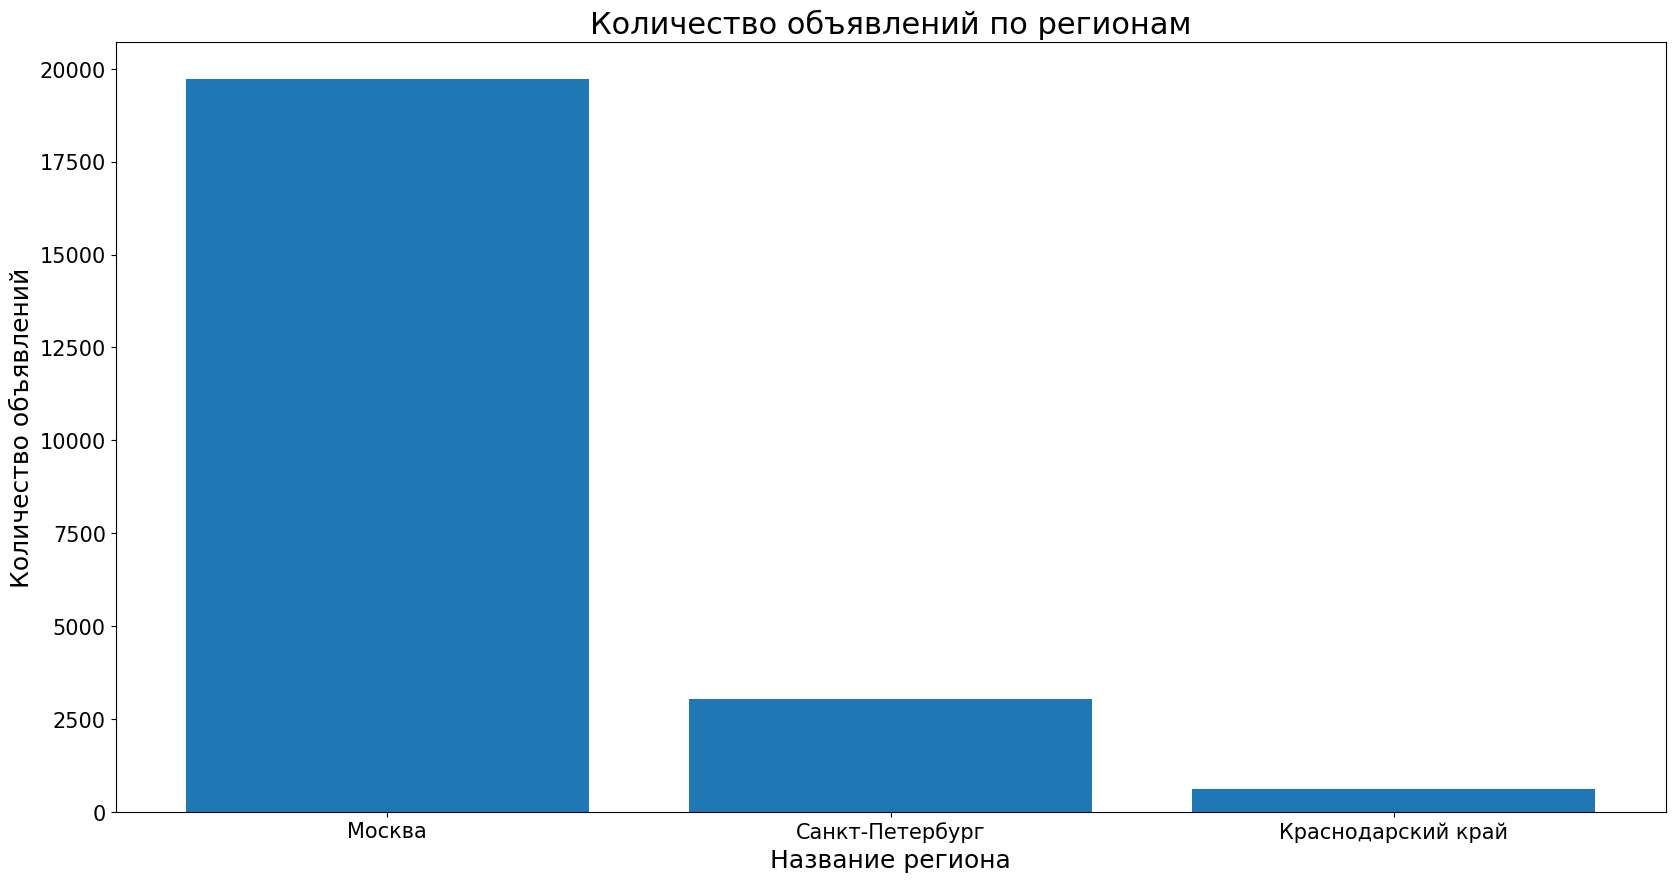

In [6]:
city = pd.DataFrame(df['Адрес'].apply(lambda x: x.split(', ')[0]).value_counts()).reset_index()
plt.figure(figsize=(20, 10))
plt.title('Количество объявлений по регионам', size =22)
plt.xlabel('Название региона', size=18)
plt.ylabel('Количество объявлений', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.bar(city['Адрес'], city['count']);

Сразу убираем не нужные регионы и сбросим индекс

In [7]:
df.drop(df.loc[df['Адрес'].apply(lambda x: x.split(', ')[0] != 'Москва')].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Обработка колонок и заполнение пропусков

## 1. Количество комнат

Из колонки извлекаем данные Количество комнат и Тип планировки
Пустые значения заполняем следующим образом:
- Количество комнат - 1 (одна) - считаем, что если количество комнат не указано, то комнат всего одна
- Тип планировки - Свободная планировка (так как половина значений NaN)

In [8]:
# создаем новый столбик с количеством комнат
df['count_room'] = df['Количество комнат'].dropna().apply(lambda x: x.split(', ')[0])
df['count_room'].isnull().sum() 
df['count_room'] = pd.to_numeric(df['count_room'])

Количество пустых ячеек: 535
Процент пустых ячеек: 2.71%


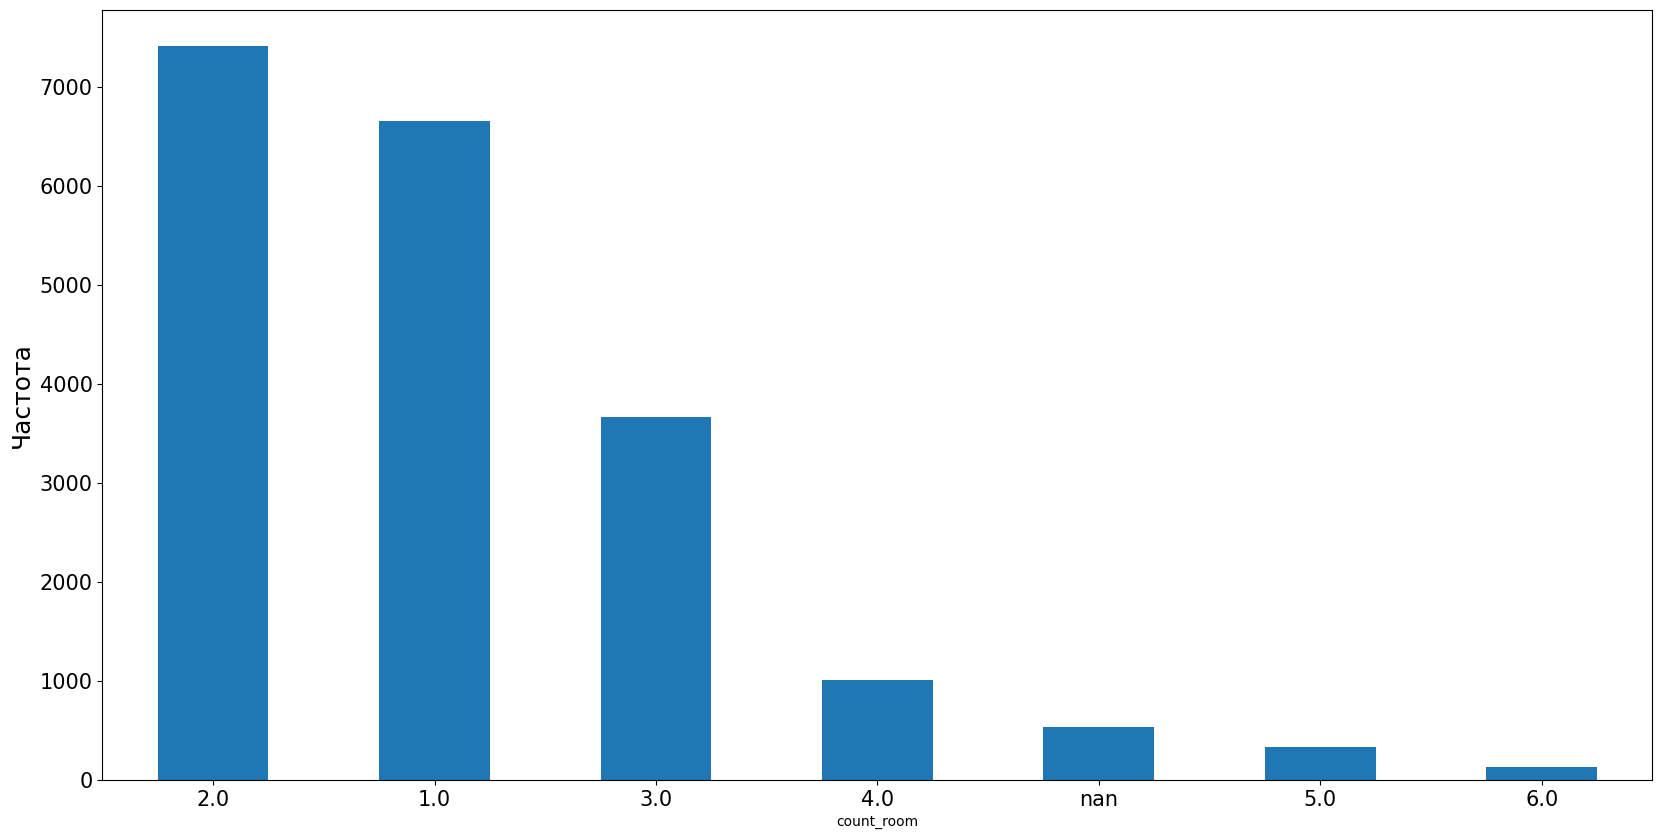

In [9]:
draw_graph(df['count_room'])
print_useful_rows_info(df['count_room'])

In [10]:
df['count_room'].fillna(1, inplace=True) # где количество комнат NaN указываем 1

In [11]:
empty_list = []
for elem in df['Количество комнат']:
    try:
        empty_list.append(elem.split(', ')[1])
    except (IndexError, AttributeError):
        empty_list.append(np.nan)

df['type_room'] = empty_list

Количество пустых ячеек: 11770
Процент пустых ячеек: 59.63%


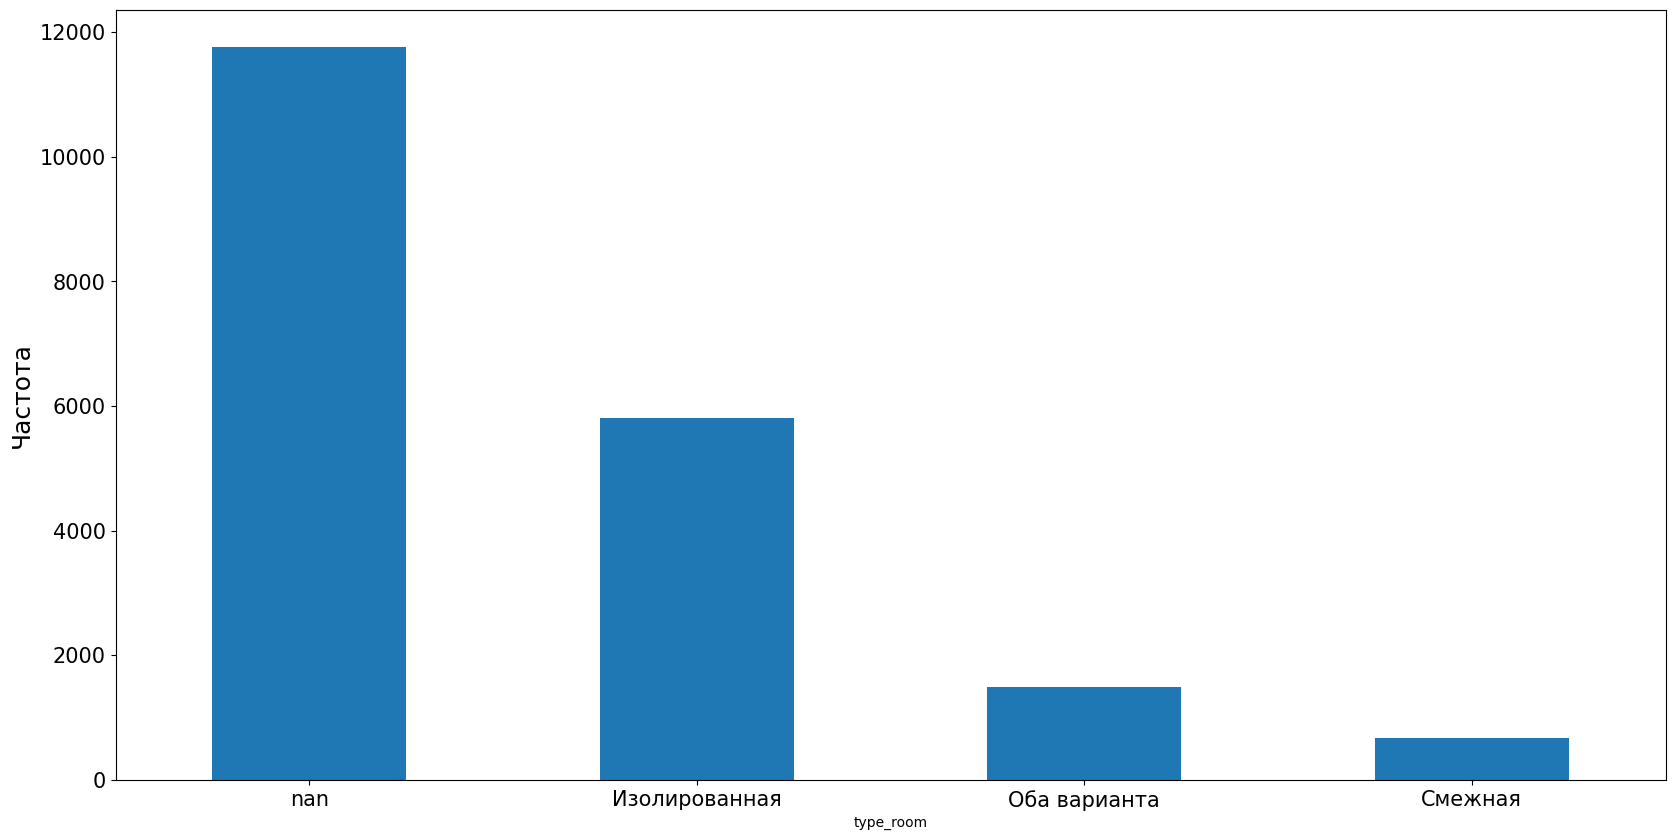

In [12]:
draw_graph(df['type_room'])
print_useful_rows_info(df['type_room'])

In [13]:
df['type_room'].fillna('Свободная планировка', inplace=True)

## 2. Тип

In [14]:
df['Тип'].value_counts()

Тип
Квартира    19737
Name: count, dtype: int64

Удаляем этот столбец, так как имеет одно уникальное значение

In [15]:
df.drop('Тип', axis=1, inplace=True)

## 3. Метро

In [16]:
# создаем колонку с названием метро
df['metro'] = df['Метро'].dropna().apply(lambda x: x.split(' (')[0])

In [17]:
print_useful_rows_info(df['metro'])

Количество пустых ячеек: 346
Процент пустых ячеек: 1.75%


Удалим из датафрейма строки с пустыми значениями в 'metro'

In [18]:
df.dropna(subset=['metro'], inplace=True)
df.reset_index(drop=True, inplace=True) # колонку с информацией по метро использовть не будем

In [19]:
# создаем колонку с временем до метро
df['time_to_metro'] = df['Метро'].dropna().apply(lambda x: x.split(' (')[1].split()[0])
df['time_to_metro'].replace({'None': np.nan}, inplace=True)
df['time_to_metro'] = pd.to_numeric(df['time_to_metro'])
print_useful_rows_info(df['time_to_metro'])

Количество пустых ячеек: 538
Процент пустых ячеек: 2.77%


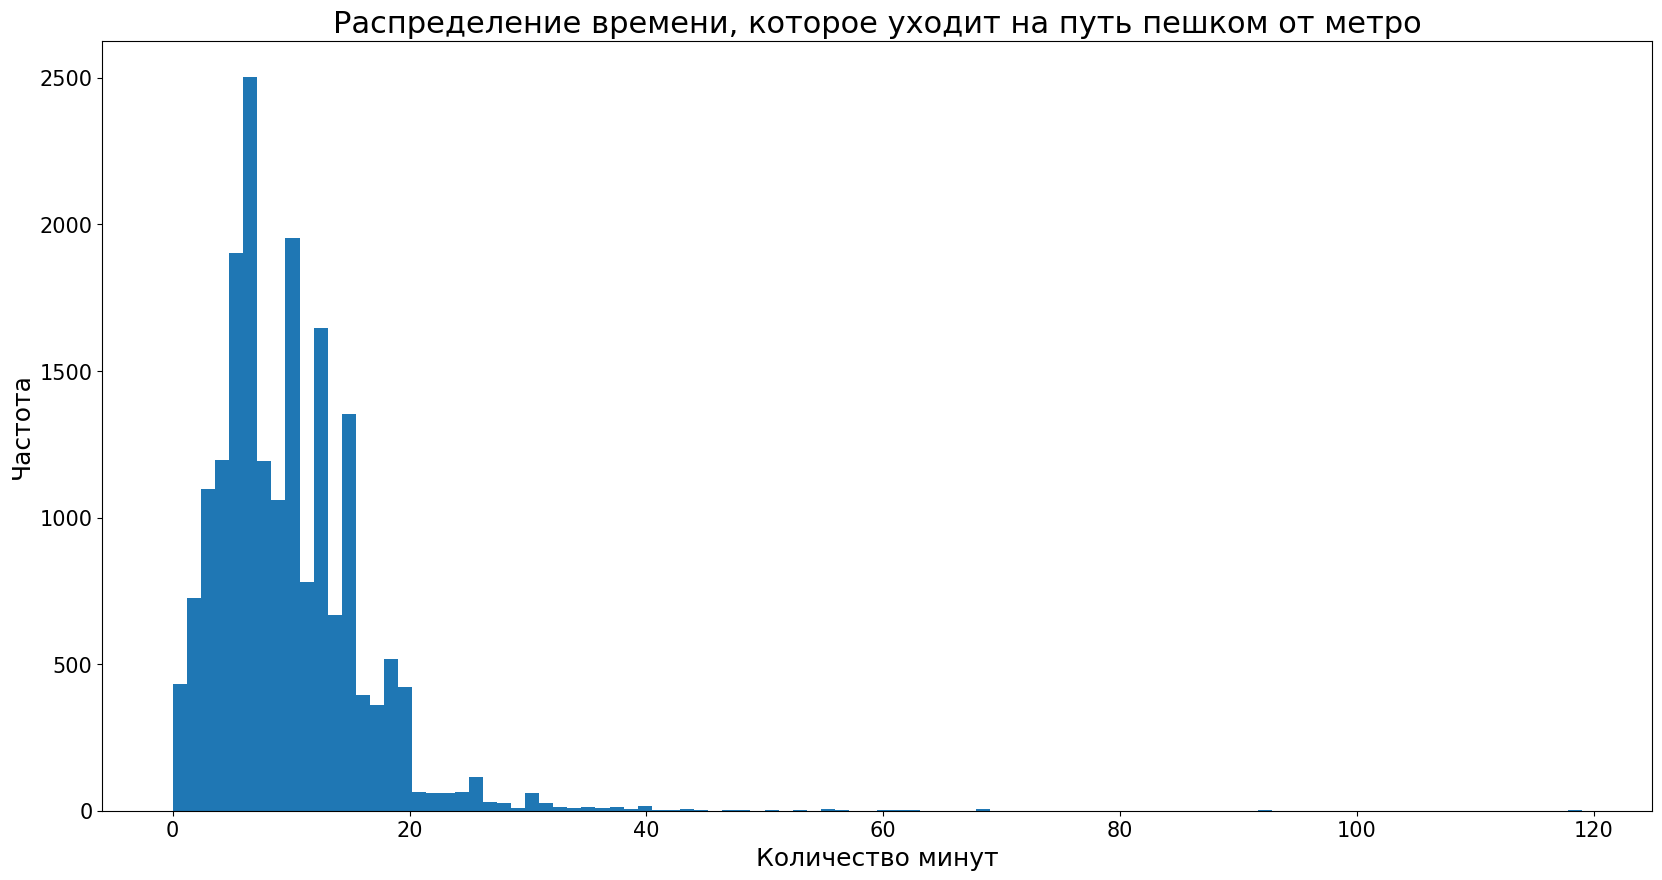

In [20]:
plt.figure(figsize=(20, 10))
plt.hist(df['time_to_metro'], bins=100)
plt.title('Распределение времени, которое уходит на путь пешком от метро', size =22)
plt.xlabel('Количество минут', size=18)
plt.ylabel('Частота', size=18)
plt.xticks(size=15)
plt.yticks(size=15);

Так как есть выбросы до 120 минут, то пустые значения заполняем Медианой

In [21]:
df['time_to_metro'].fillna(df['time_to_metro'].median(), inplace=True)
print_useful_rows_info(df['time_to_metro'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 4. Адрес

In [22]:
# избавимся от части адреса после ш.
df['Адрес_new'] = [elem.split('ш. ')[0] for elem in df['Адрес']]

Напишем функцию, которая с помощью библетеки сможем по адресу объекта выгрузить координаты.
Дальше эти координаты мы сможем использовать для нахождения расстояния от центра Москвы до адреса объекта

In [23]:
empty_list = []
def do_geocode(address, attempt=1, max_attempts=5):
  try:
    empty_list.append(Nominatim(user_agent="my_request").geocode(address, timeout=None)[-1])
  except GeocoderTimedOut:
    if attempt <= max_attempts:
      return do_geocode(address, attempt=attempt+1)
    raise

In [24]:
for row in tqdm(df['Адрес_new']):
  try:
    do_geocode(row)
  except:
    empty_list.append('None')

100%|███████████████████████████████████| 19391/19391 [2:42:31<00:00,  1.99it/s]


In [25]:
df['lat'] = [elem[0] for elem in empty_list]
df['long'] = [elem[1] for elem in empty_list]

In [26]:
df['lat'].value_counts()

lat
N                     729
55.79818205            63
55.735334449999996     46
55.72377795            37
55.8083413             34
                     ... 
55.68378195             1
55.68059305             1
55.68007045             1
55.66733465             1
55.6472318              1
Name: count, Length: 9884, dtype: int64

In [27]:
# удалим строчки без координат
df = df[df['lat'] != 'N']
df.reset_index(drop=True, inplace=True)

In [28]:
df['distance_center'] = [round(geodesic((df['lat'][i], df['long'][i]), (KREMLIN_LAT, KREMLIN_LONG)).km, 2) for i in range(len(df))]

In [29]:
df = df[df['distance_center'] < 100]

In [432]:
#df.to_csv('df.csv', index_label=False)

In [1017]:
df = pd.read_csv('df.csv')
df.drop(['level_0', 'index'], axis=1, inplace=True)

In [1018]:
df.shape

(18658, 31)

In [1019]:
# Создаём новый параметр, зависящий от расстояния
res = ''
def circle(text):
  if text < 2.5:
    res = 'Садовое кольцо'
  elif 2.5 < text < 5:
    res = 'ТТК'
  elif 5 < text < 17:
    res = 'МКАД'
  else:
    res = 'ЗАМКАД'
  return res

In [1020]:
text = df['distance_center']
text = text.apply(circle)
df['district'] = text

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


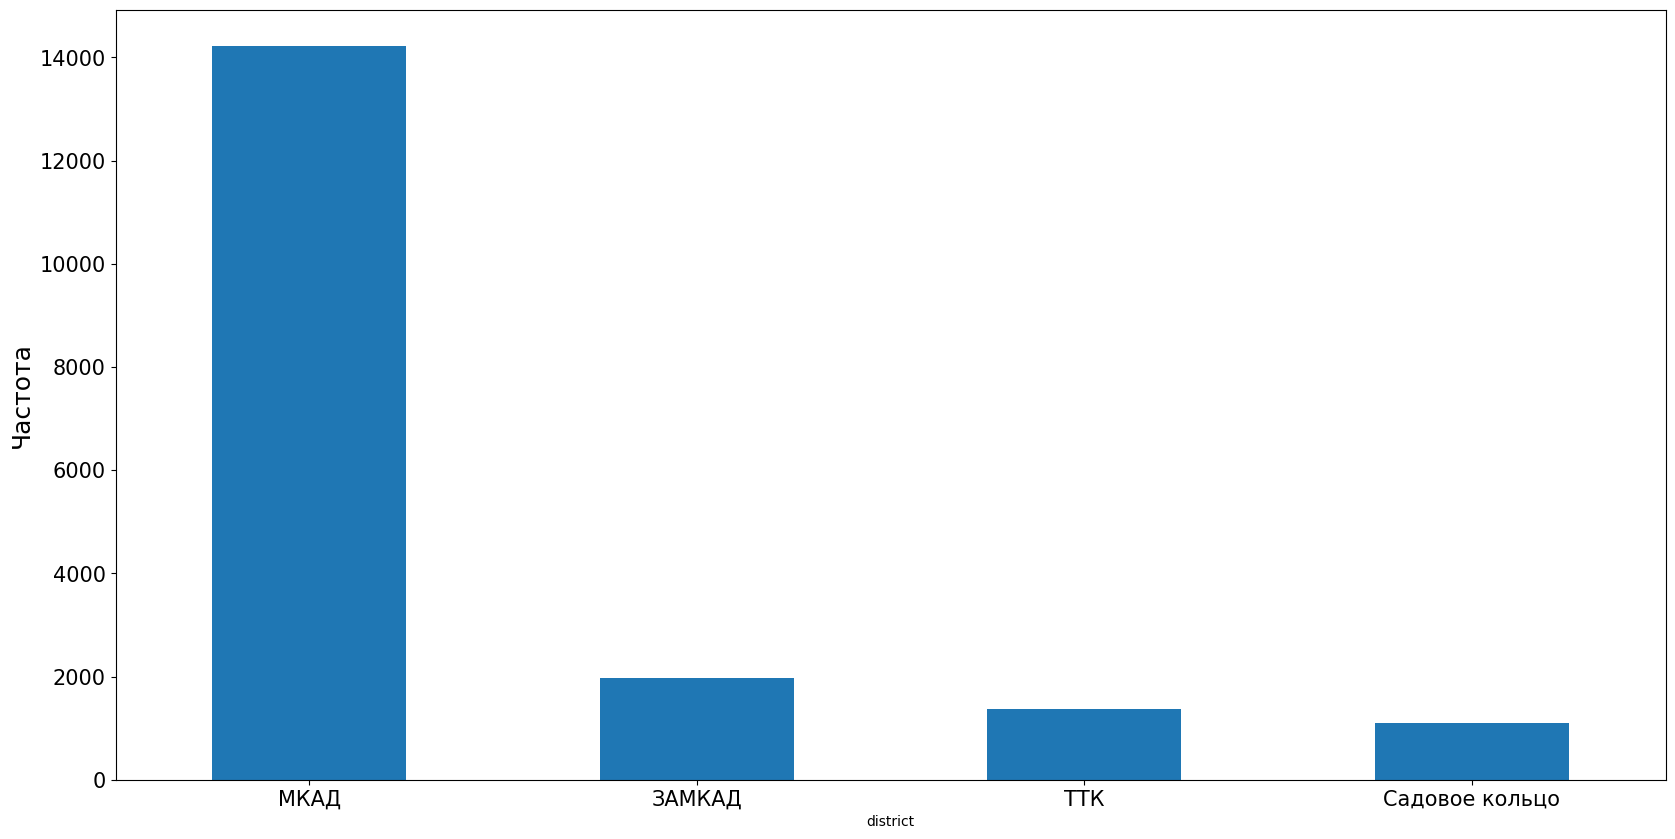

In [1021]:
draw_graph(df['district'])
print_useful_rows_info(df['district'])

## 5. Площадь, м2

Извлечем только первое значение - общая площадь квартиры

In [1022]:
df['area'] = df['Площадь, м2'].dropna().apply(lambda x: x.split('/')[0])
df['area'] = pd.to_numeric(df['area'])
print_useful_rows_info(df['area'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 6. Дом

Извлечем этаж квартиры, этажность дома и тип дома и создадим новые колонки

In [1023]:
# этаж квартиры
df['floor'] = df['Дом'].dropna().apply(lambda x: x.split('/')[0])
df['floor'] = pd.to_numeric(df['floor'])
print_useful_rows_info(df['floor'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


In [1024]:
# этажность дома
df['amount_floors'] = df['Дом'].dropna().apply(lambda x: x.split('/')[1].split(', ')[0])
df['amount_floors'] = pd.to_numeric(df['amount_floors'])
print_useful_rows_info(df['amount_floors'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


Количество пустых ячеек: 2743
Процент пустых ячеек: 14.7%


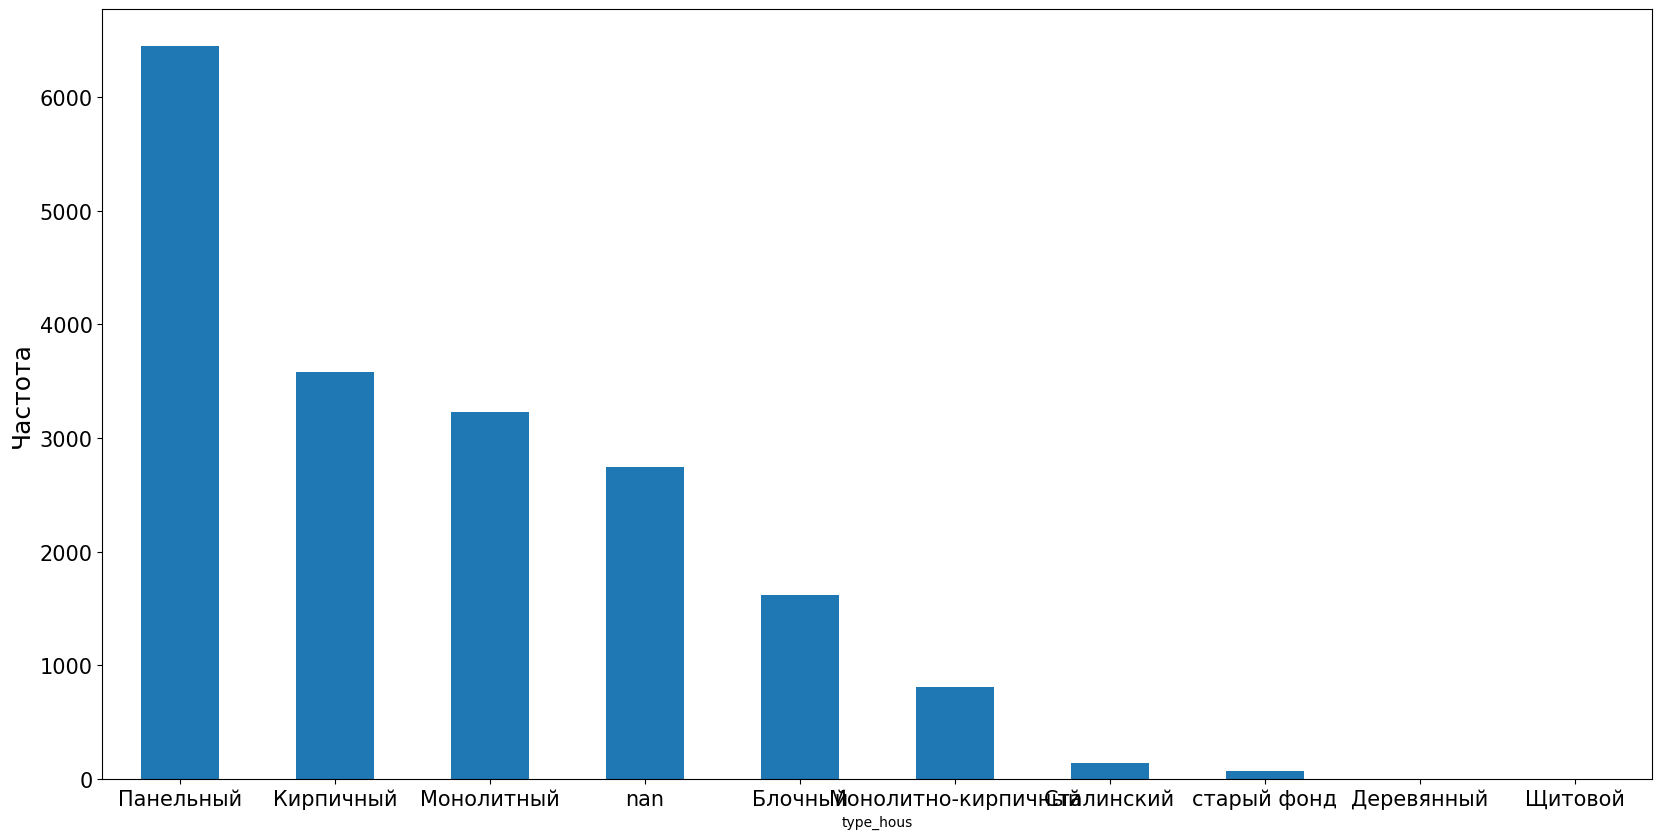

In [1025]:
# тип дома
empty_list = []
for elem in df['Дом']:
    try:
        empty_list.append(elem.split('/')[1].split(', ')[1])
    except (IndexError, AttributeError):
        empty_list.append(np.nan)

df['type_hous'] = empty_list
draw_graph(df['type_hous'])
print_useful_rows_info(df['type_hous'])

In [1026]:
df['type_hous'].value_counts()

type_hous
Панельный              6452
Кирпичный              3583
Монолитный             3233
Блочный                1622
Монолитно-кирпичный     812
Сталинский              140
старый фонд              68
Деревянный                4
Щитовой                   1
Name: count, dtype: int64

Пустые значения заполним Модой. Щитовой и Деревянный также заменим Модой

In [1027]:
df['type_hous'].fillna('Панельный', inplace=True)

In [1028]:
df['type_hous'].replace(['Деревянный', 'Щитовой'],['Панельный', 'Панельный'], inplace=True)
print_useful_rows_info(df['type_hous'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 7. Парковка

Количество пустых ячеек: 10580
Процент пустых ячеек: 56.7%


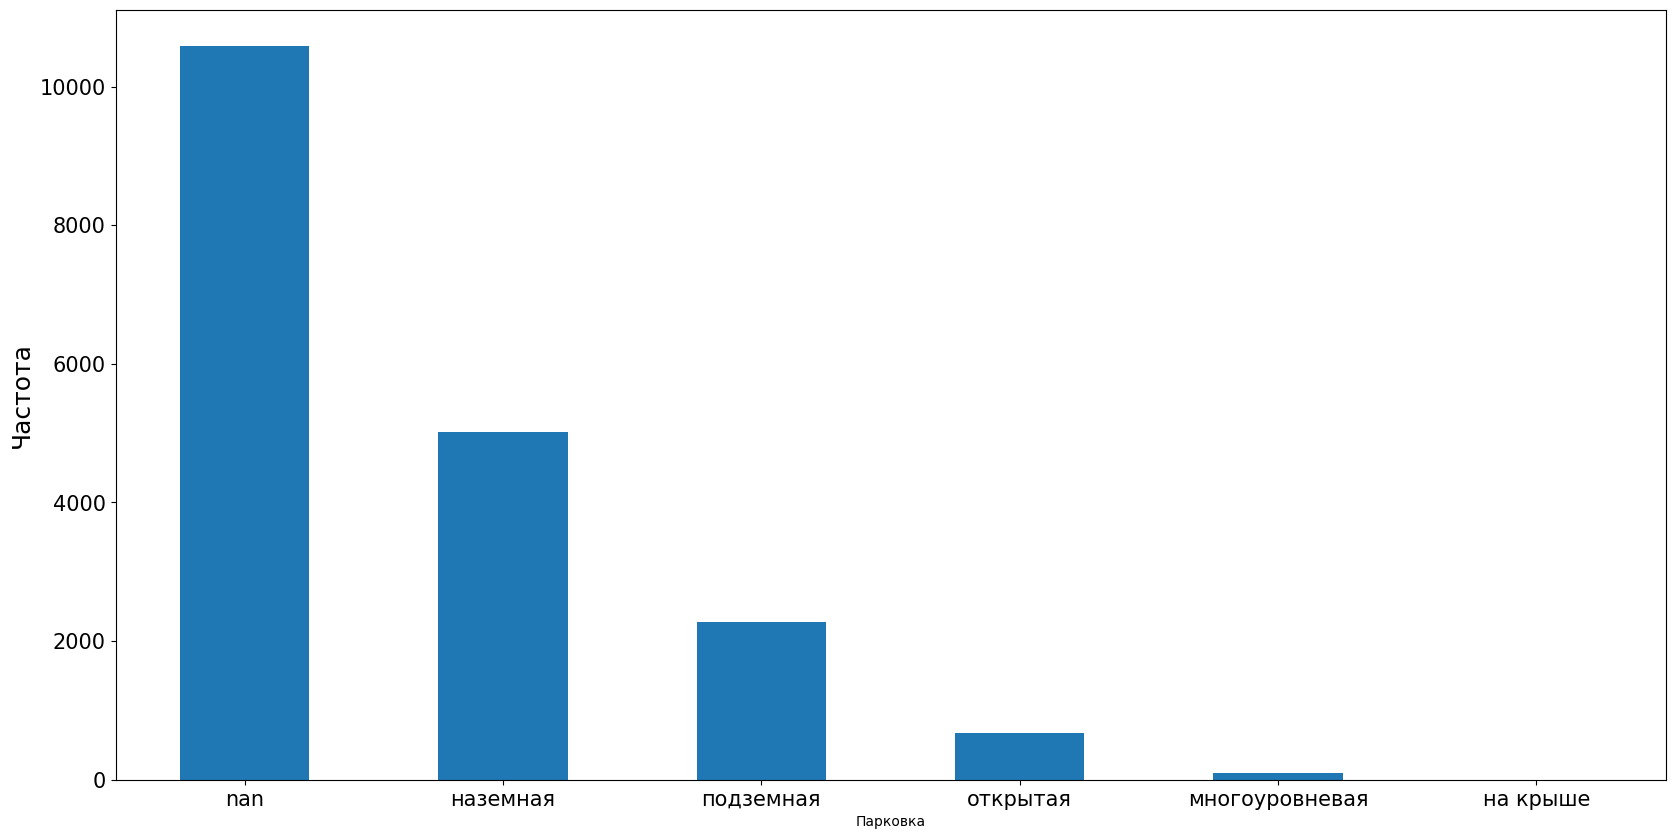

In [1029]:
draw_graph(df['Парковка'])
print_useful_rows_info(df['Парковка'])

In [1030]:
# Заменяем пропуски в столбце [‘Парковка’]  на  'Открытая' (по сути отсутствие парковки)
df['Парковка'] = df['Парковка'].fillna('открытая')
print_useful_rows_info(df['Парковка'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 8. Цена

Так как цена аренды указана в руб, долларах и евро - необходимо конвертировать в одну валюту. Будем конвертировать по курсу ЦБ РФ в руб

In [1031]:
data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
rate_usd = data['Valute']['USD']['Value']
rate_eur = data['Valute']['EUR']['Value']

In [1032]:
df['price'] = df['Цена'].apply(lambda x: int(x.split('.')[0]))
df['currency_rent'] = df['Цена'].apply(lambda x: x.split('/')[0].split(' ')[1])
df['price'] = [int(val['price'] * rate_usd) if val['currency_rent'] == '$' else val['price'] if val['currency_rent'] == 'руб.' else int(val['price'] * rate_eur) for key, val in df.iterrows()]

In [1033]:
print_useful_rows_info(df['price'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


Также из этой колонки можно изъять следующие данные:
- длительность аренды
- предоплата за количество месяцев

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


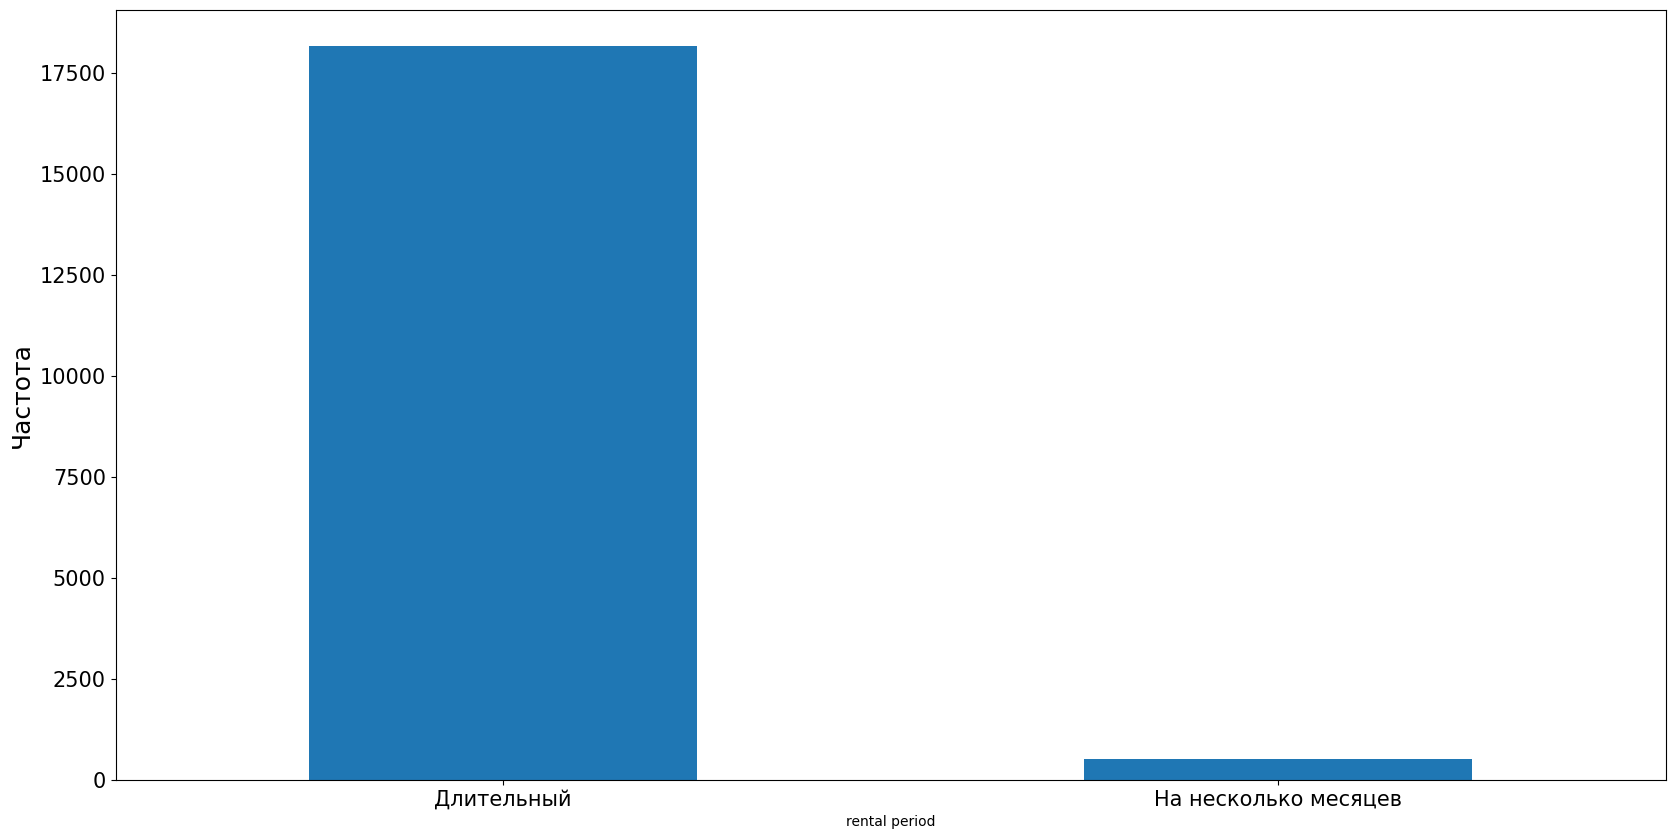

In [1034]:
# создаем новую колонку со сроком аренды
p = []
for elem in df['Цена']:
    if elem.find('Срок аренды') != -1:
        for stro in elem.split(', '):
            if stro.find('Срок аренды') != -1:
                p.append(stro.split(' - ')[-1])
    else:
        p.append(np.nan)
        
df['rental period'] = p
print_useful_rows_info(df['rental period'])
draw_graph(df['rental period'])

Количество пустых ячеек: 281
Процент пустых ячеек: 1.51%


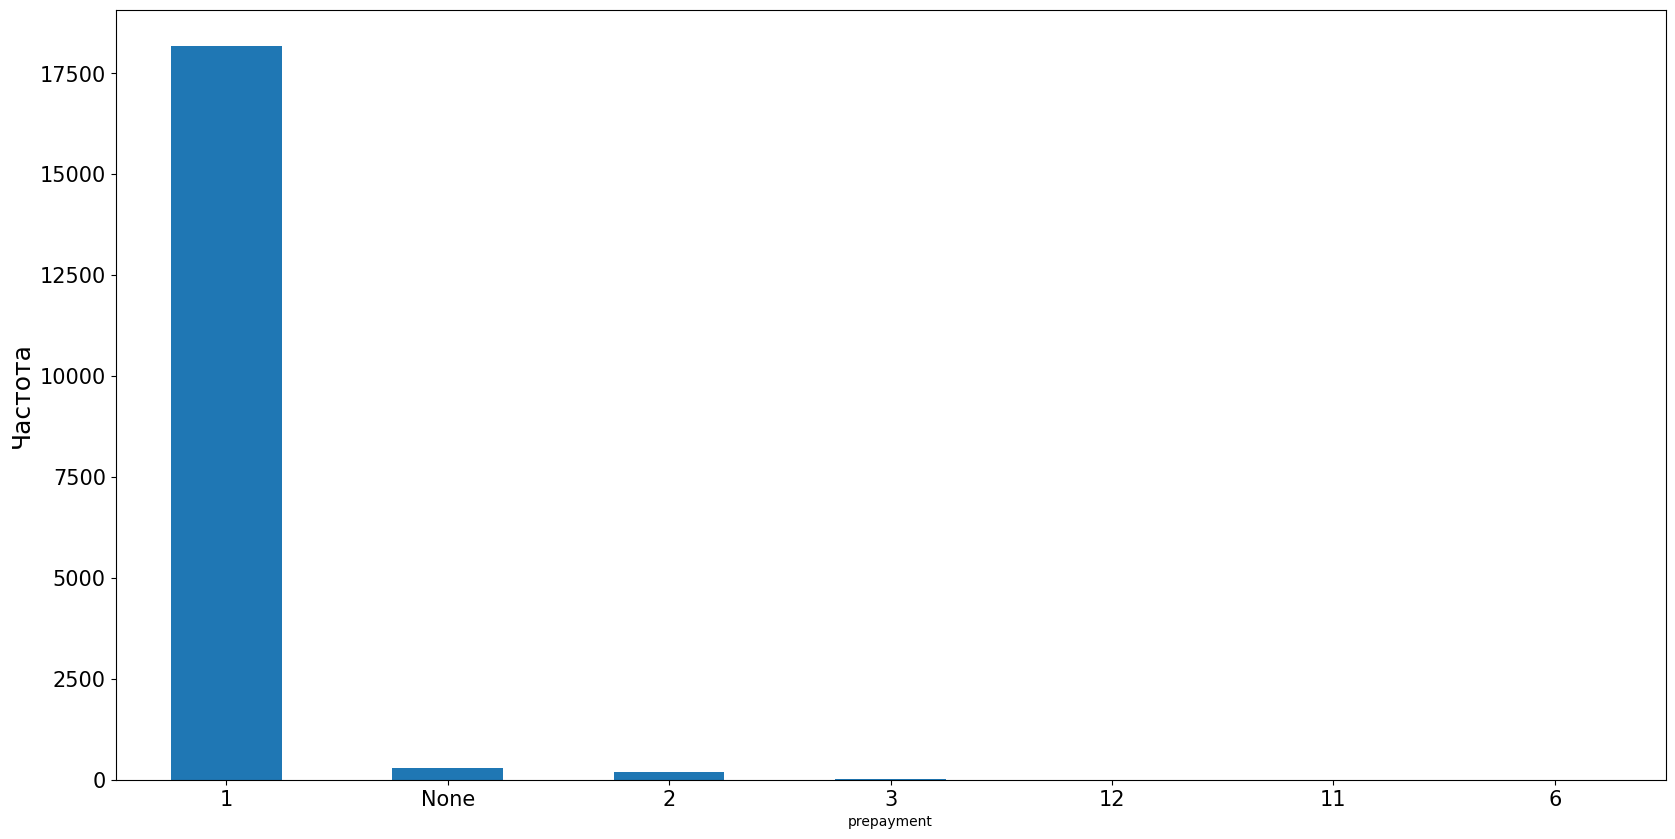

In [1035]:
# создаем новую колонку с предоплатой(кол-во месяцев)
p = []
for elem in df['Цена']:
    if elem.find('Предоплата') != -1:
        for stro in elem.split(', '):
            if stro.find('Предоплата') != -1:
                p.append(stro.split(' ')[1])
    else:
        p.append(None)
    
df['prepayment'] = p
print_useful_rows_info(df['prepayment'])
draw_graph(df['prepayment'])

In [1036]:
df['prepayment'].value_counts()

prepayment
1     18165
2       197
3        10
12        3
11        1
6         1
Name: count, dtype: int64

In [1037]:
# пустые значения заменим модой
df['prepayment'].fillna(1, inplace=True)
print_useful_rows_info(df['prepayment'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 9. Телефоны

Контактные телефоны агентов и владельцев объектов не могут влиять на стоимость аренды. Удаляем эту колонку

In [1038]:
df.drop('Телефоны', axis=1, inplace=True)

## 10. Описание

Очень разрозненная информация по каждому объекту, поэтому будет удалять эту колонку

In [1039]:
df.drop('Описание', axis=1, inplace=True)

## 11. Ремонт

Количество пустых ячеек: 2375
Процент пустых ячеек: 12.73%


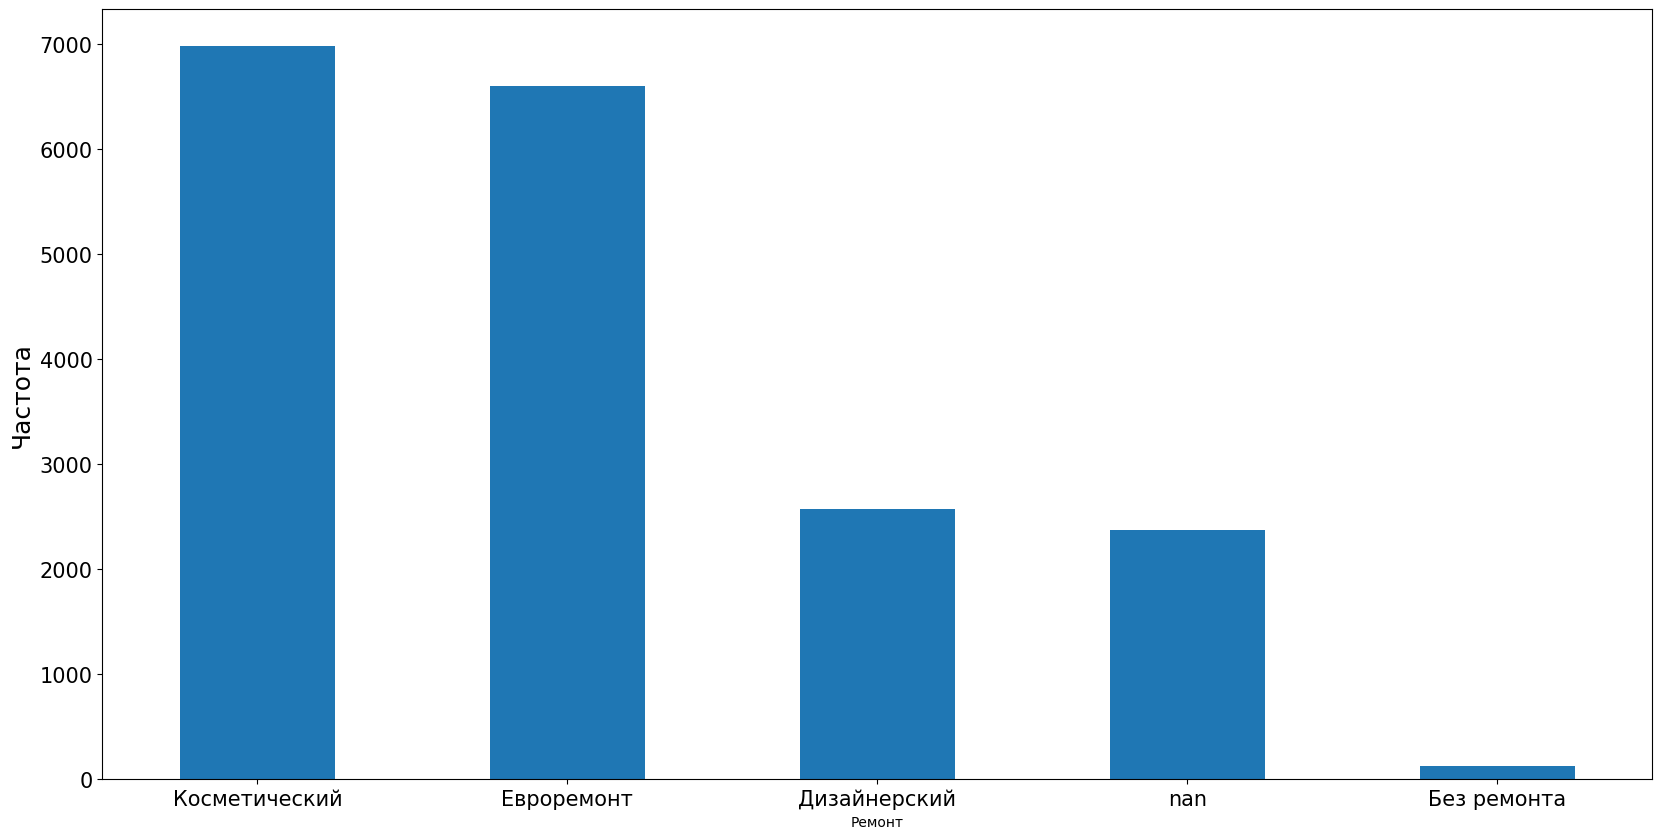

In [1040]:
print_useful_rows_info(df['Ремонт'])
draw_graph(df['Ремонт'])

In [1041]:
# Заменяем пропуски в столбце ['Ремонт'] на 'Без ремонта'. Считаем, что отсутствие ифнормации о ремонте - это его отсутсвие
df['Ремонт'].fillna('Без ремонта', inplace=True)
print_useful_rows_info(df['Ремонт'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 12. Площадь комнат, м2

In [1042]:
print_useful_rows_info(df['Площадь комнат, м2'])

Количество пустых ячеек: 6774
Процент пустых ячеек: 36.31%


Количество пустых ячеек велико, пренебрежем этой колонкой, учитывая то что у нас уже есть общая площадь 

In [1043]:
df.drop('Площадь комнат, м2', axis=1, inplace=True)

## 13. Балкон

In [1044]:
df['Балкон'].value_counts()

Балкон
Балкон (1)                6082
Лоджия (1)                4754
Балкон (1), Лоджия (1)     580
Лоджия (2)                 511
Балкон (2)                 395
Балкон (3)                  43
Лоджия (3)                  41
Балкон (1), Лоджия (2)      20
Балкон (2), Лоджия (2)      20
Балкон (2), Лоджия (1)      16
Лоджия (4)                   5
Балкон (3), Лоджия (1)       4
Балкон (4)                   4
Балкон (1), Лоджия (3)       4
Балкон (2), Лоджия (3)       3
Балкон (1), Лоджия (4)       2
Балкон (3), Лоджия (3)       1
Балкон (4), Лоджия (4)       1
Name: count, dtype: int64

In [1045]:
print_useful_rows_info(df['Балкон'])

Количество пустых ячеек: 6172
Процент пустых ячеек: 33.08%


In [1046]:
# Заменяем пропуски в столбце [‘Балкон’]  на моду (Балкон(1))
df['Балкон'].fillna(df['Балкон'].mode()[0], inplace=True)
df.reset_index(drop=True, inplace=True)

In [1047]:
# создадим два столбца - в первом проставим 1, если есть балкон и 0, если его нет
                   #- во втором поставим 1, есть лоджия и 0, если ее нет 
                   #- две колонки по количеству балконов и лоджий
df['balcony'] = [1 if elem.find('Балкон') != -1 else 0 for elem in df['Балкон']]
df['loggia'] = [1 if elem.find('Лоджия') != -1 else 0 for elem in df['Балкон']]
k = []
for i in range(len(df)):
    if df['balcony'][i] == 1:
        k.append(df['Балкон'][i].split(' (')[1][0])
    else:
        k.append(0)
df['balcony_count'] = k
t = []
for i in range(len(df)):
    if df['loggia'][i] == 1:
        t.append(df['Балкон'][i].split(' (')[-1][0])
    else:
        t.append(0)
df['loggia_count'] = t

In [1048]:
print_useful_rows_info(df['balcony'])
print_useful_rows_info(df['loggia'])
print_useful_rows_info(df['balcony_count'])
print_useful_rows_info(df['loggia_count'])
df['balcony_count'] = pd.to_numeric(df['balcony_count'])
df['loggia_count'] = pd.to_numeric(df['loggia_count'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%
Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%
Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%
Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 14. Окна

Количество пустых ячеек: 4859
Процент пустых ячеек: 26.04%


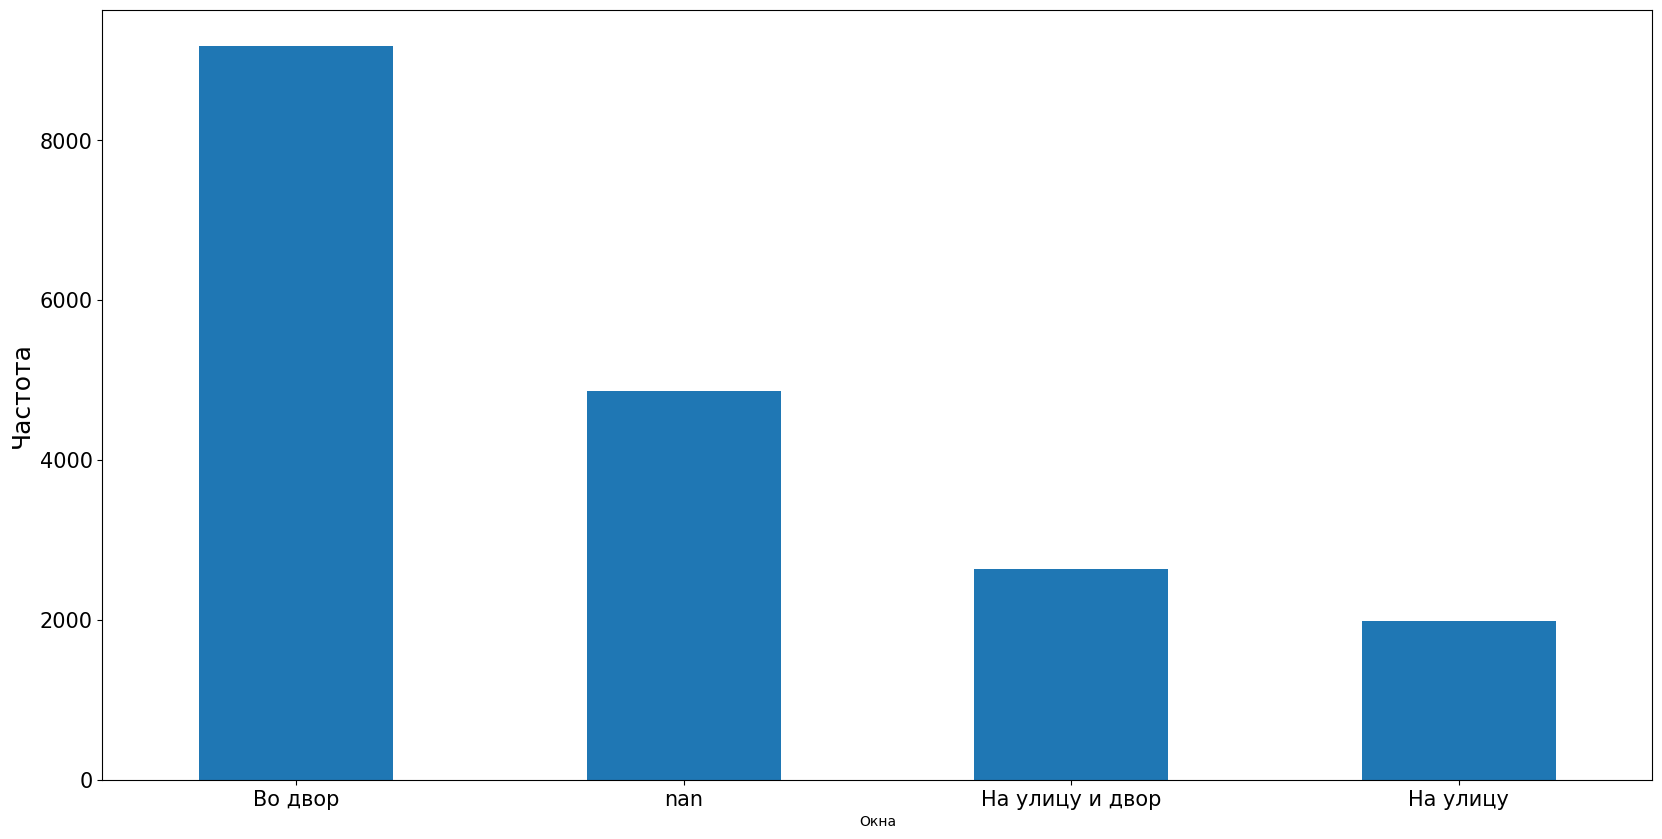

In [1049]:
print_useful_rows_info(df['Окна'])
draw_graph(df['Окна'])

In [1050]:
# Заменяем пропуски в столбце [‘Окна’]  на моду (Во двор)
df['Окна'].fillna(df['Окна'].mode()[0], inplace=True)

In [1051]:
print_useful_rows_info(df['Окна'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 15. Санузел

In [1052]:
df['Санузел'].value_counts()

Санузел
Совмещенный (1)                    8015
Раздельный (1)                     5837
Совмещенный (2)                    1237
Совмещенный (1), Раздельный (1)     680
Раздельный (2)                      376
Совмещенный (3)                     216
Совмещенный (2), Раздельный (1)     172
Совмещенный (4)                      72
Раздельный (3)                       37
Совмещенный (3), Раздельный (1)      26
Совмещенный (1), Раздельный (2)      25
Совмещенный (2), Раздельный (2)      19
Раздельный (4)                       15
Совмещенный (3), Раздельный (3)       6
Совмещенный (4), Раздельный (1)       5
Совмещенный (4), Раздельный (2)       4
Совмещенный (1), Раздельный (3)       2
Совмещенный (2), Раздельный (3)       2
Совмещенный (2), Раздельный (4)       1
Name: count, dtype: int64

In [1053]:
print_useful_rows_info(df['Санузел'])

Количество пустых ячеек: 1911
Процент пустых ячеек: 10.24%


In [1054]:
#Заменяем пропуски в столбце ['Санузел'] на моду
processed_data1 = []

for item in df['Санузел']:
    processed_item1 = re.sub(r'\(\d+\)', '', str(item))
    processed_data1.append(processed_item1.strip())

mode_toilet = pd.Series(processed_data1).mode()[0]
print(f'Самый часто встречаемый тип санузла - {mode_toilet}')

Самый часто встречаемый тип санузла - Совмещенный


Пустые значения заполняем модой и количество указываем 1

In [1055]:
df['Санузел'].fillna('Cовмещенный (1)', inplace=True)

In [1056]:
print_useful_rows_info(df['Санузел'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


In [1057]:
# создадим два столбца - в первом проставим 1, если санузел Совмещенный и 0, если его нет
                   #- во втором поставим 1, есть анузел Раздельный и 0, если его нет
                   #- две колонки по количеству типов санузлов
df['toilet_join'] = [1 if elem.find('Совмещенный') != -1 else 0 for elem in df['Санузел']]
df['toilet_sep'] = [1 if elem.find('Раздельный') != -1 else 0 for elem in df['Санузел']]
k = []
for i in range(len(df)):
    if df['toilet_join'][i] == 1:
        k.append(df['Санузел'][i].split(' (')[1][0])
    else:
        k.append(0)
df['toilet_join_count'] = k
t = []
for i in range(len(df)):
    if df['toilet_sep'][i] == 1:
        t.append(df['Санузел'][i].split(' (')[-1][0])
    else:
        t.append(0)
df['toilet_sep_count'] = t

df['toilet_join_count'] = pd.to_numeric(df['toilet_join_count'])
df['toilet_sep_count'] = pd.to_numeric(df['toilet_sep_count'])

## 16. Можно с детьми/животными

Количество пустых ячеек: 4624
Процент пустых ячеек: 24.78%


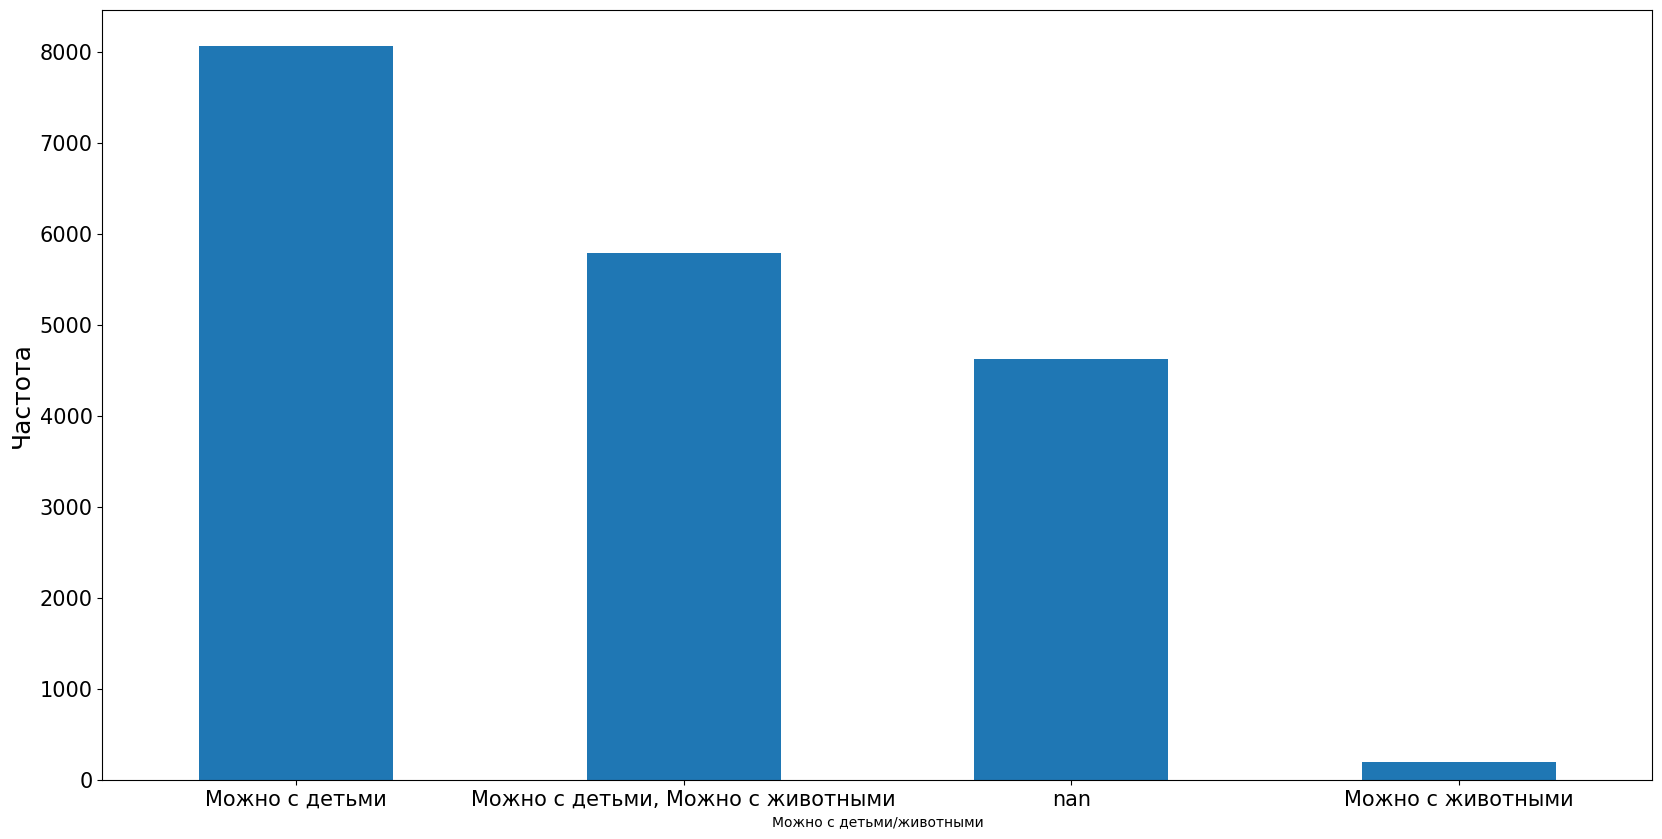

In [1058]:
draw_graph(df['Можно с детьми/животными'])
print_useful_rows_info(df['Можно с детьми/животными'])

Создадим две колонки children и animal - укажем 1, если можно и 0, если нельзя.
Для пустых ячеек укажем 0

In [1059]:
x = []
for elem in df['Можно с детьми/животными']:
    if type(elem) == str:
        if elem.find('детьми') != -1:
            x.append(1)
        else:
            x.append(0)
    else:
        x.append(0)

df['children'] = x

In [1060]:
x = []
for elem in df['Можно с детьми/животными']:
    if type(elem) == str:
        if elem.find('животными') != -1:
            x.append(1)
        else:
            x.append(0)
    else:
        x.append(0)

df['animal'] = x

In [1061]:
print_useful_rows_info(df['children'])
print_useful_rows_info(df['animal'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%
Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


## 17. Дополнительно

In [1062]:
print_useful_rows_info(df['Дополнительно'])

Количество пустых ячеек: 239
Процент пустых ячеек: 1.28%


В этой колонке мало пропущенных значений и находится информация о наличии мебели в квартире. Найдем список всех позиций

In [1063]:
r = []
for elem in df['Дополнительно']:
    if not isinstance(elem, float):
        for i in elem.split(', '):
            r.append(i)

list_dop = list(set(r))
list_dop

['Ванна',
 'Интернет',
 'Холодильник',
 'Кондиционер',
 'Мебель в комнатах',
 'Телевизор',
 'Телефон',
 'Мебель на кухне',
 'Посудомоечная машина',
 'Душевая кабина',
 'Стиральная машина']

Создадим по столбцу каждому элементу списка list_dop и поставим 1, если элемент присутствует и 0 - если отсутствует

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


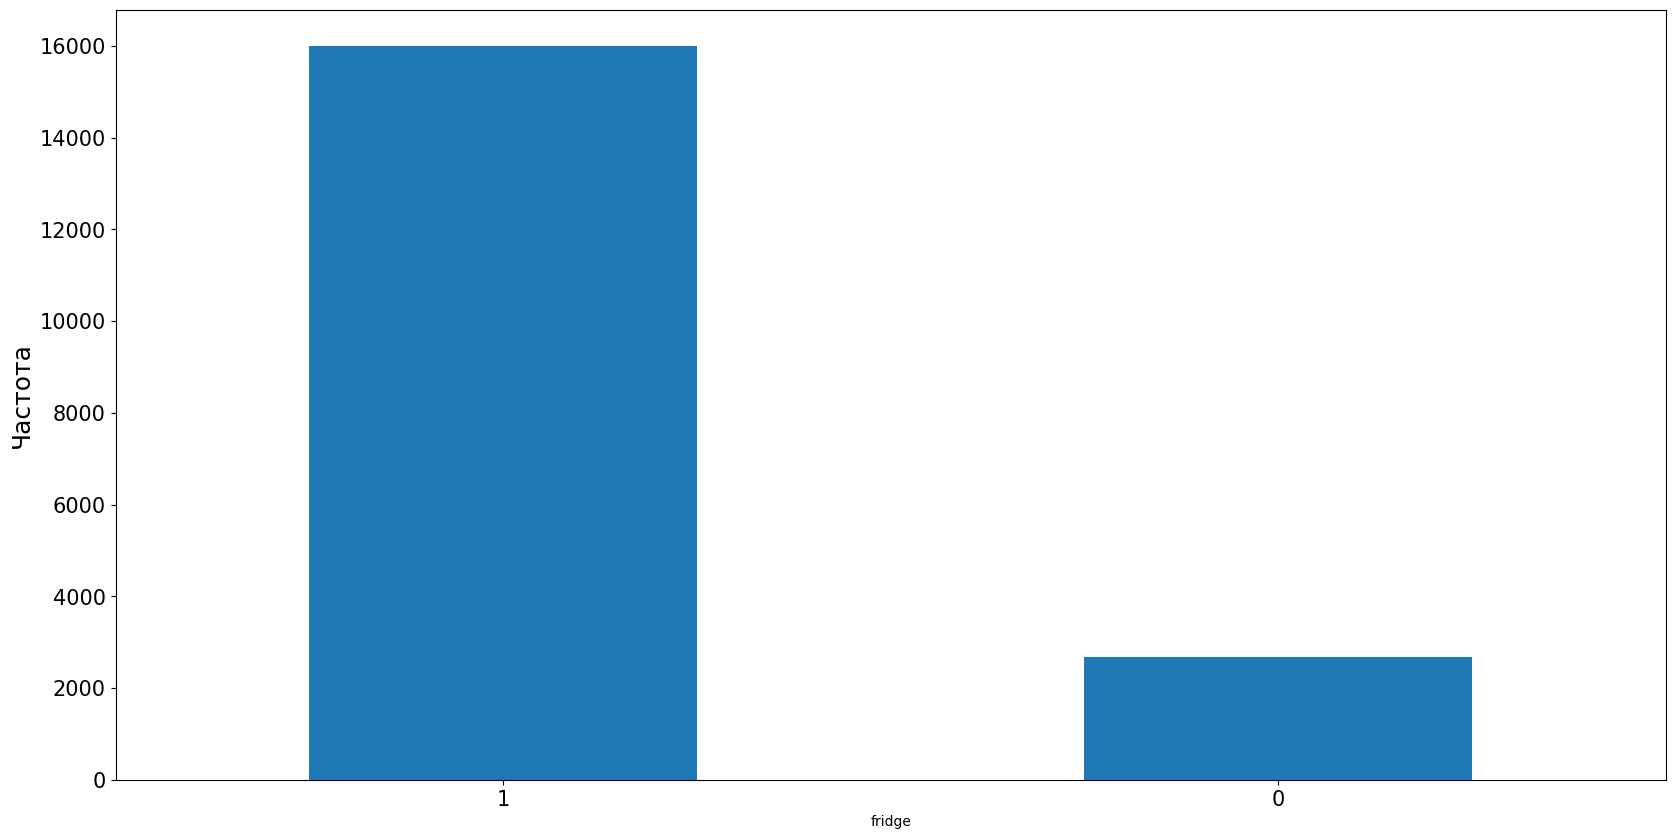

In [1064]:
# наличие холодильника
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Холодильник') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['fridge'] = empty_list
draw_graph(df['fridge'])
print_useful_rows_info(df['fridge'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


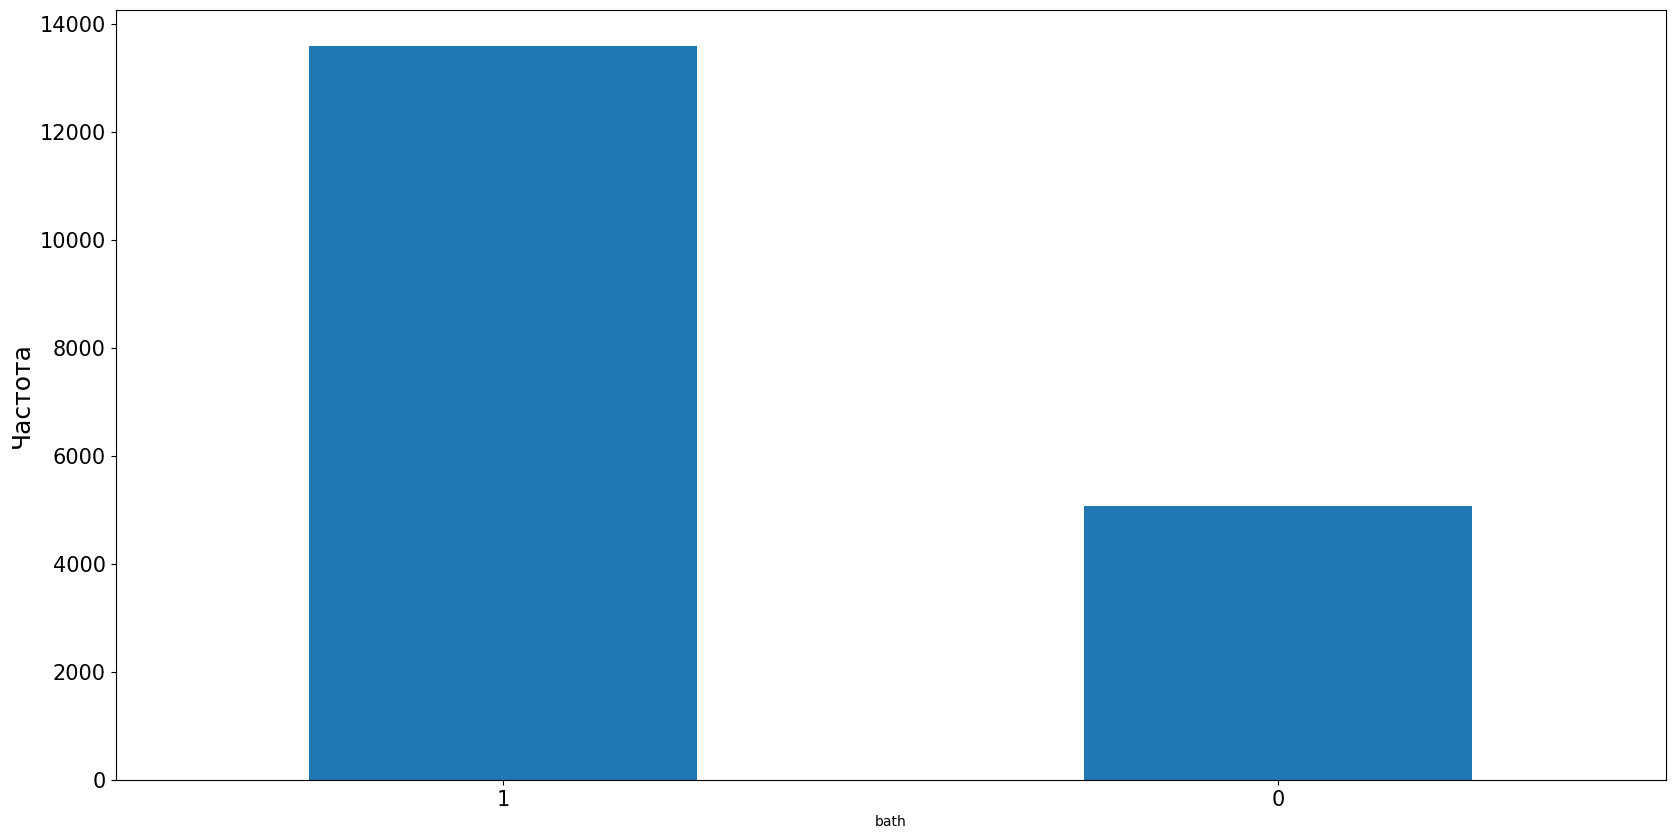

In [1065]:
# наличие ванны
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Ванна') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['bath'] = empty_list
draw_graph(df['bath'])
print_useful_rows_info(df['bath'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


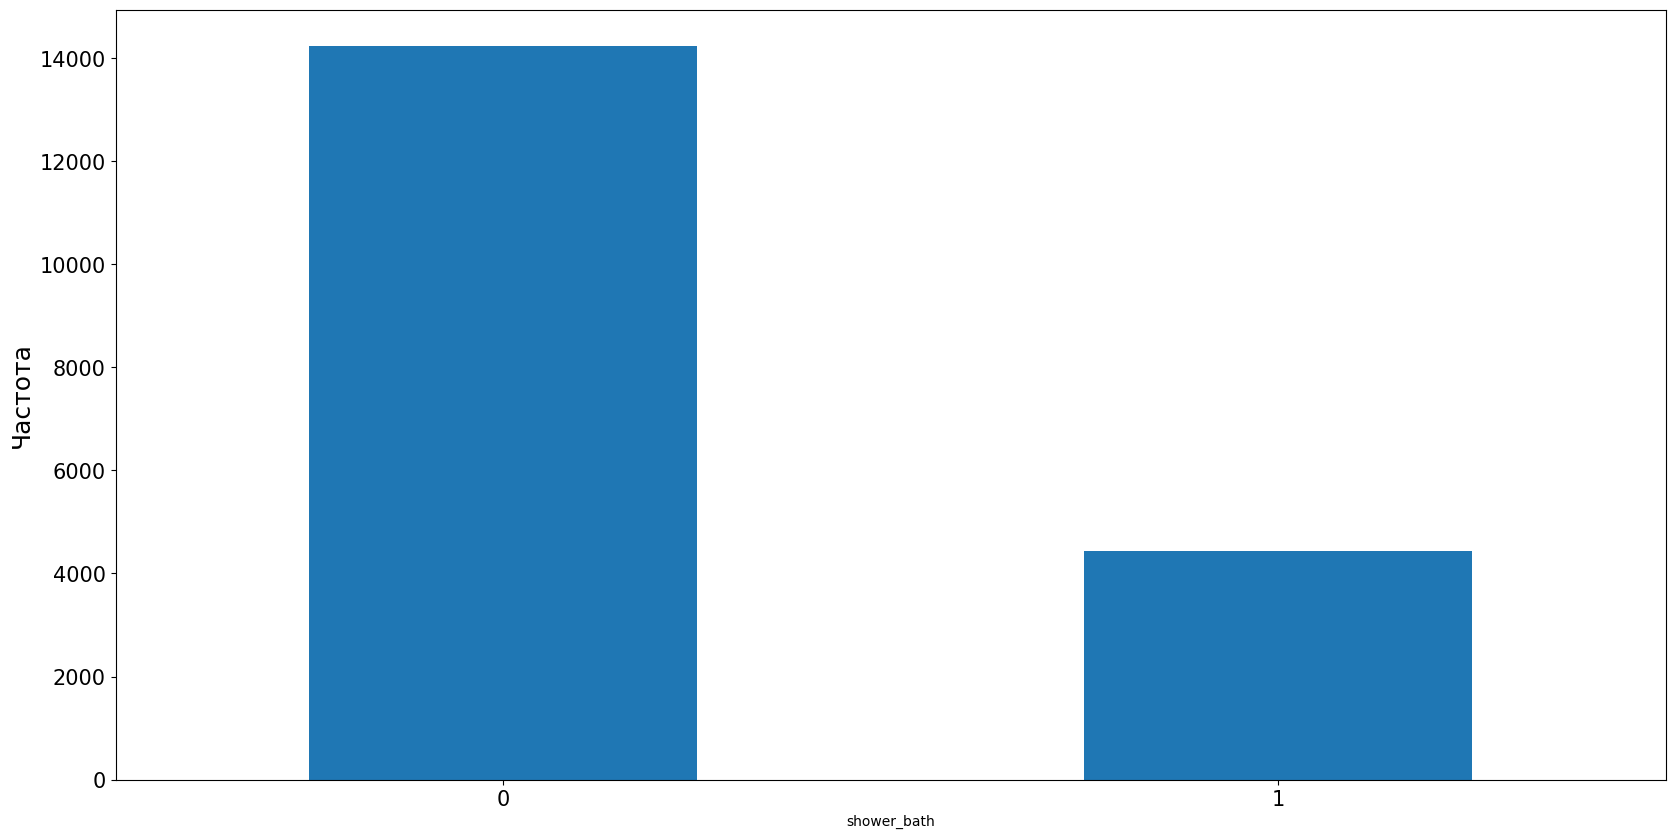

In [1066]:
# наличие душевой кабины
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Душевая кабина') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['shower_bath'] = empty_list
draw_graph(df['shower_bath'])
print_useful_rows_info(df['shower_bath'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


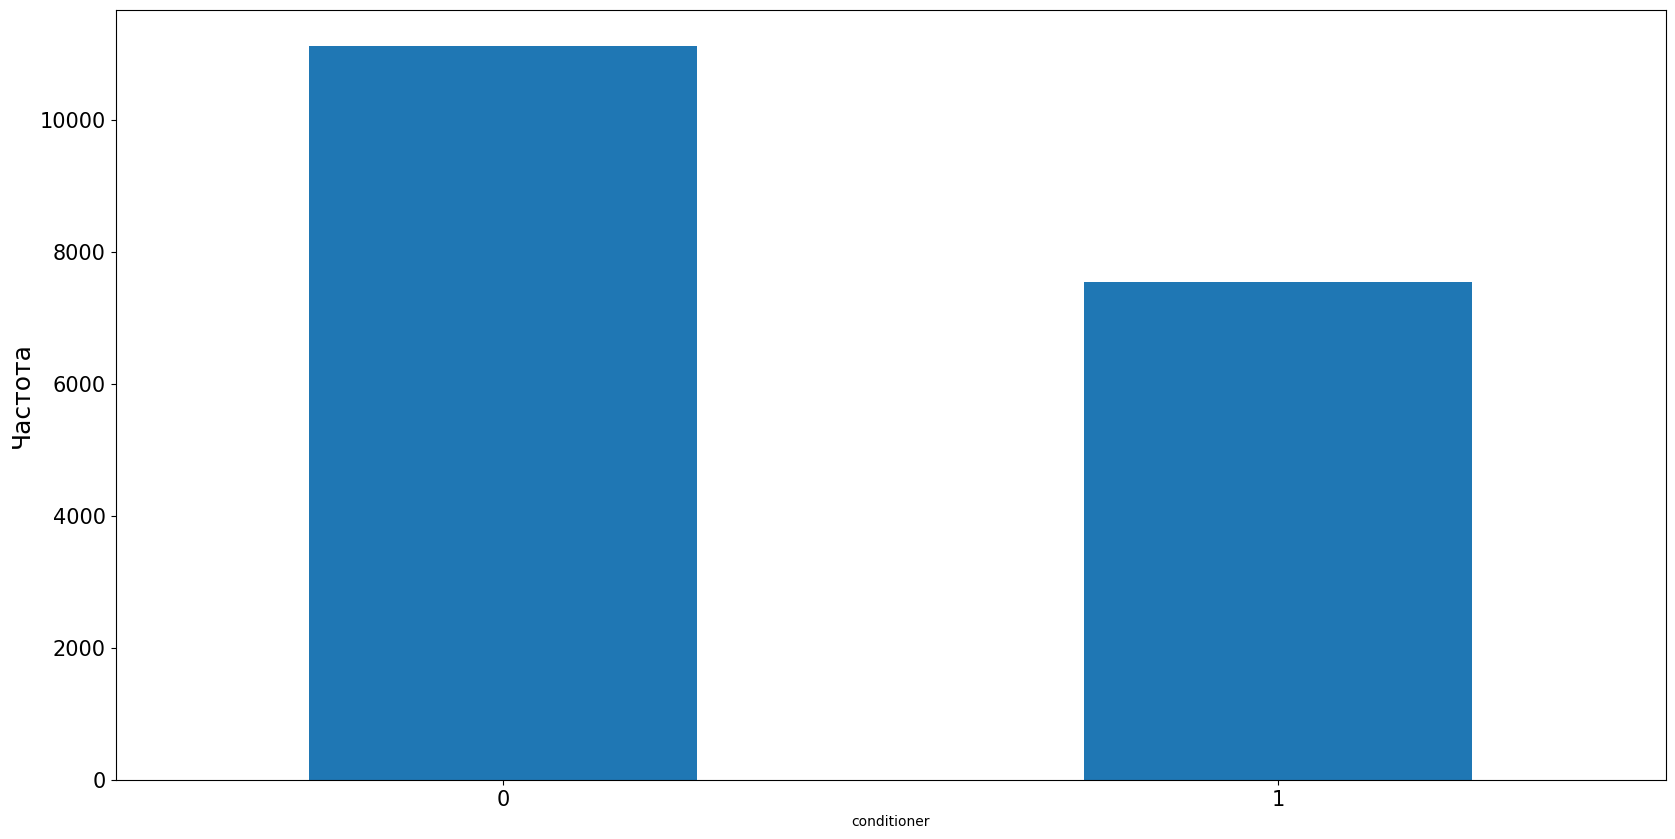

In [1067]:
# наличие кондиционера
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Кондиционер') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['conditioner'] = empty_list
draw_graph(df['conditioner'])
print_useful_rows_info(df['conditioner'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


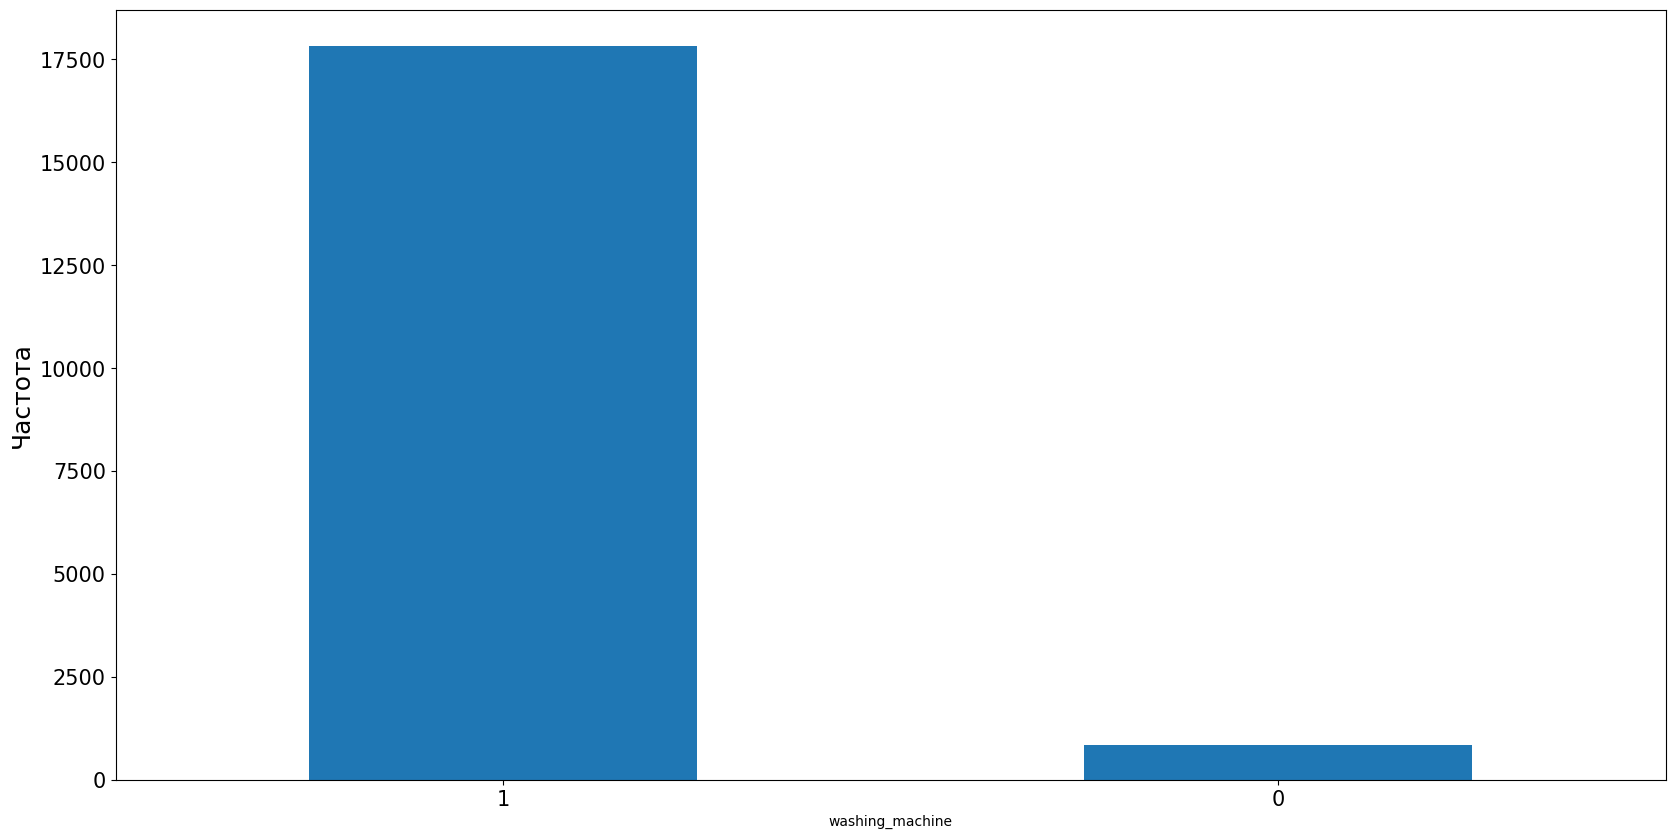

In [1068]:
# наличие стиральной машины
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Стиральная машина') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['washing_machine'] = empty_list
draw_graph(df['washing_machine'])
print_useful_rows_info(df['washing_machine'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


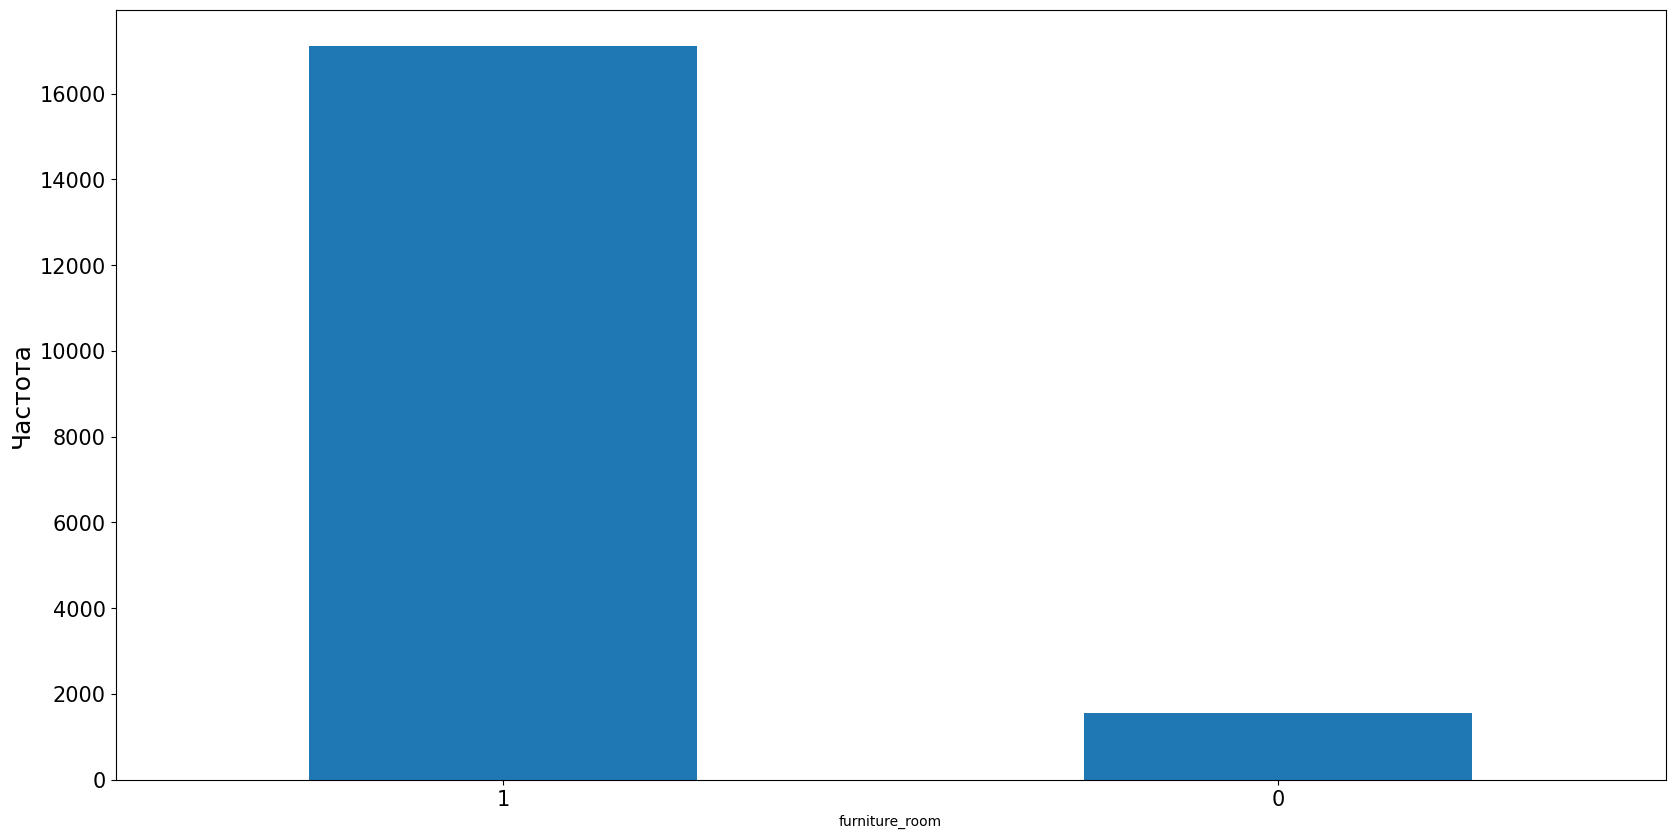

In [1069]:
# наличие мебели в комнатах
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Мебель в комнатах') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['furniture_room'] = empty_list
draw_graph(df['furniture_room'])
print_useful_rows_info(df['furniture_room'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


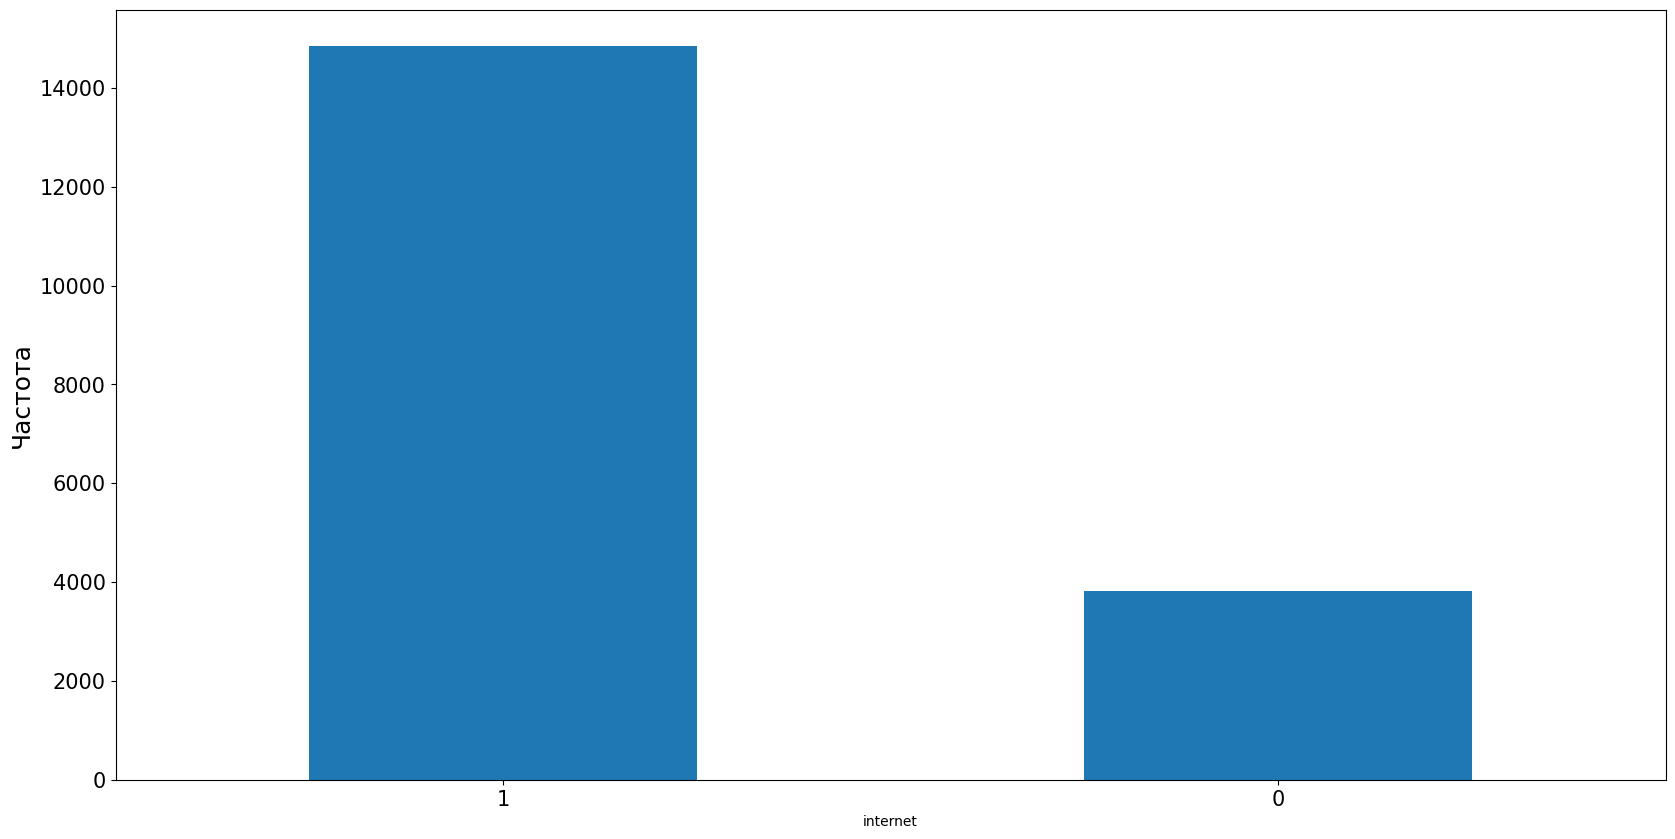

In [1070]:
# наличие интернета
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Интернет') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['internet'] = empty_list
draw_graph(df['internet'])
print_useful_rows_info(df['internet'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


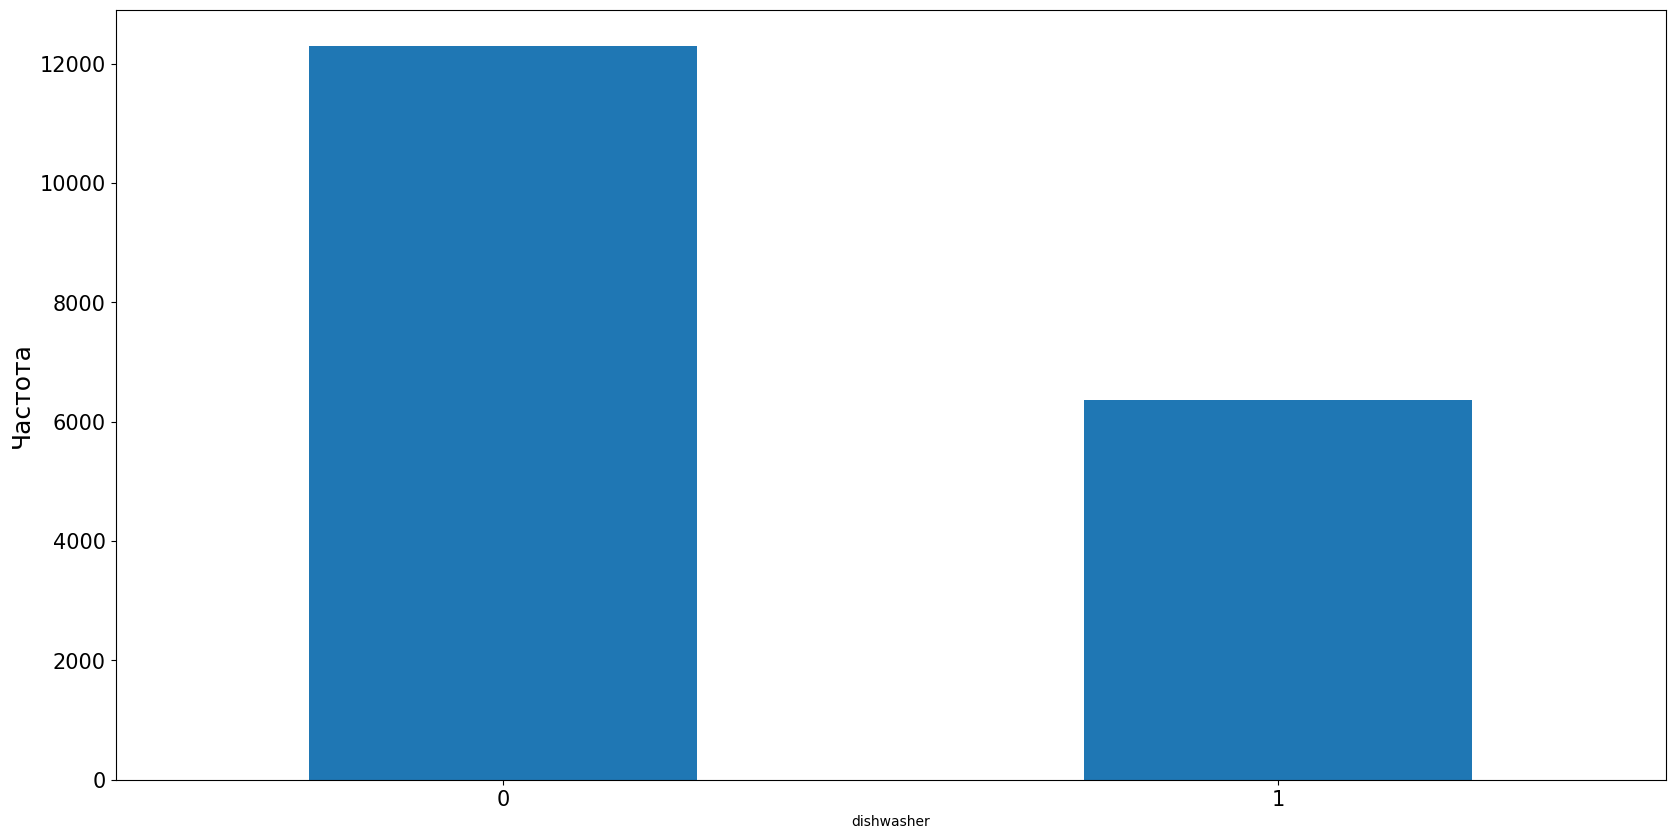

In [1071]:
# наличие посудомочной машины
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Посудомоечная машина') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['dishwasher'] = empty_list
draw_graph(df['dishwasher'])
print_useful_rows_info(df['dishwasher'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


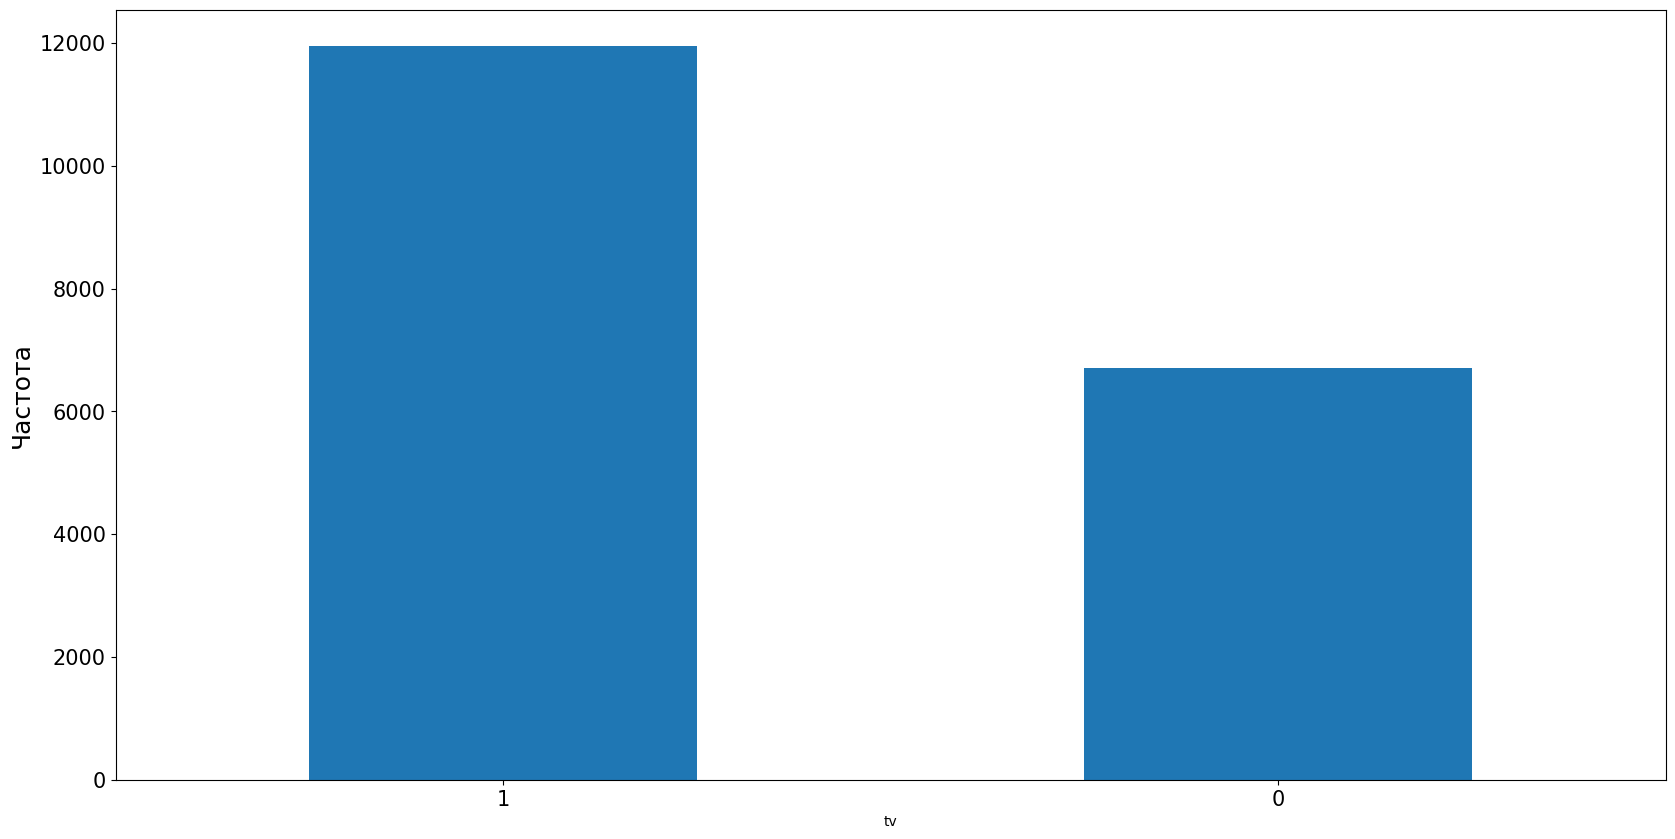

In [1072]:
# наличие телевизора
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Телевизор') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['tv'] = empty_list
draw_graph(df['tv'])
print_useful_rows_info(df['tv'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


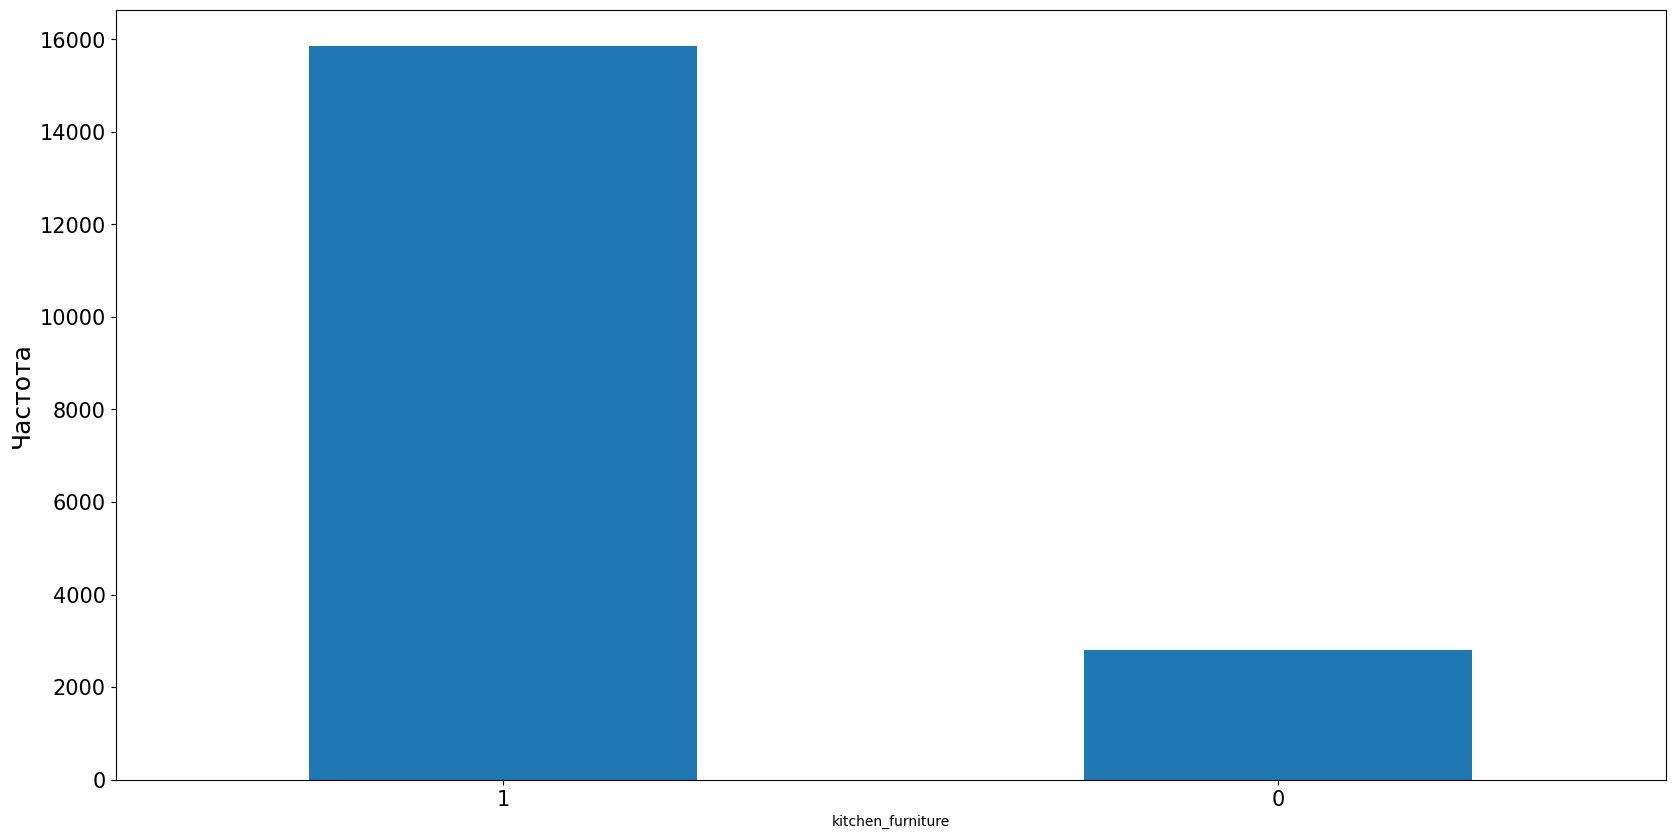

In [1073]:
# наличие мебели на кухне
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Мебель на кухне') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['kitchen_furniture'] = empty_list
draw_graph(df['kitchen_furniture'])
print_useful_rows_info(df['kitchen_furniture'])

Количество пустых ячеек: 0
Процент пустых ячеек: 0.0%


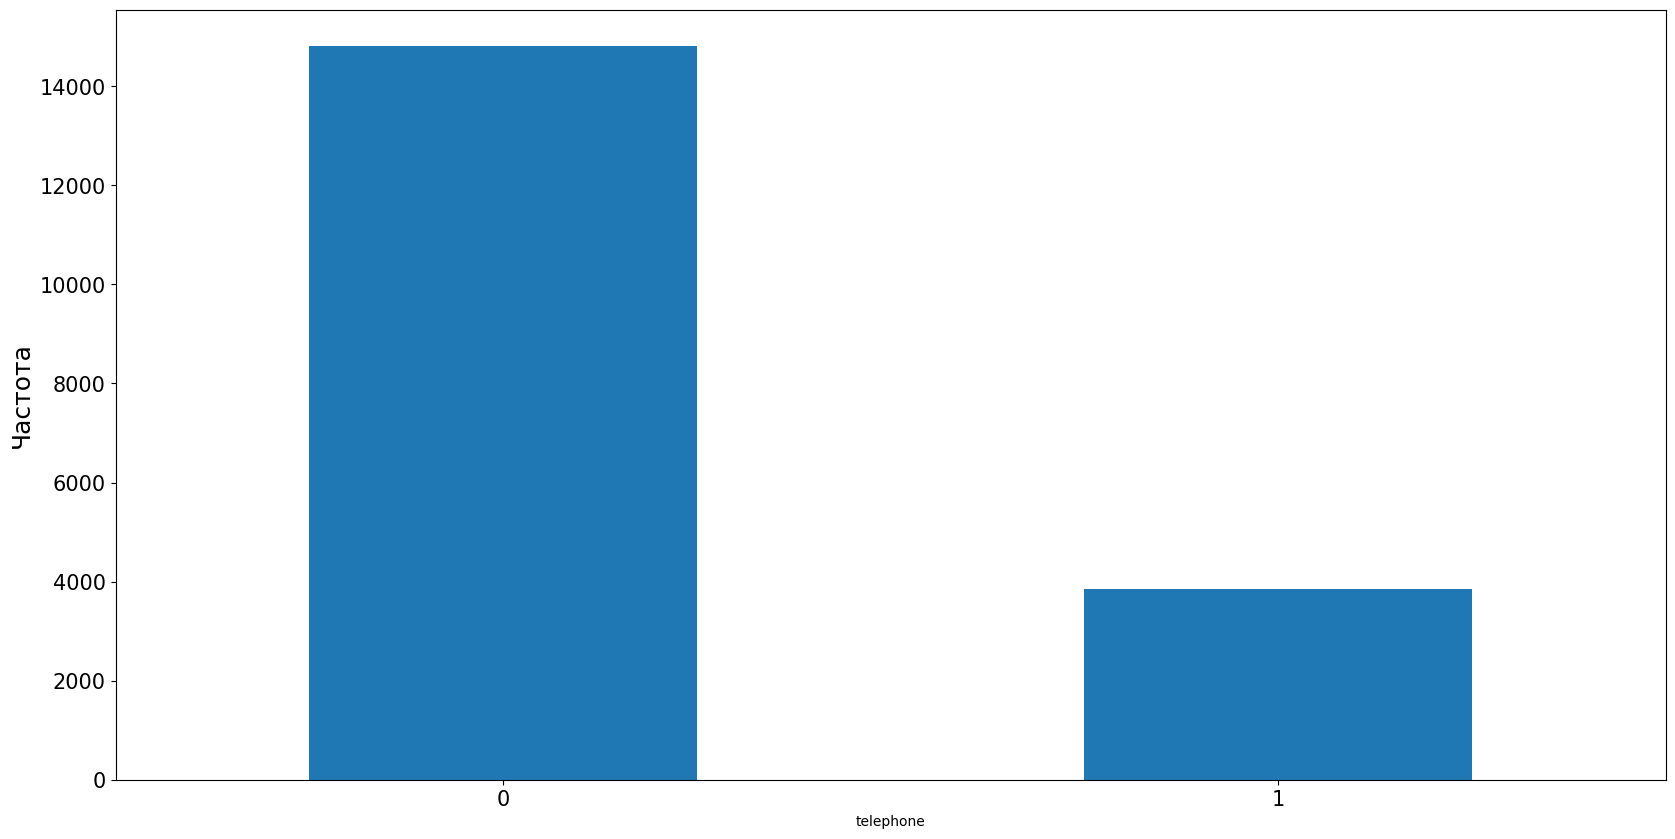

In [1074]:
# наличие телефона
empty_list = []
for elem in df['Дополнительно']:
    try:
        empty_list.append((1 if elem.find('Телефон') != -1 else 0))
    except AttributeError:
        empty_list.append(0)

df['telephone'] = empty_list
draw_graph(df['telephone'])
print_useful_rows_info(df['telephone'])

## 18. Название ЖК

In [1075]:
print_useful_rows_info(df['Название ЖК'])

Количество пустых ячеек: 14658
Процент пустых ячеек: 78.56%


Много пропусков, удаляем признак

In [1076]:
df.drop('Название ЖК', axis=1, inplace=True)

## 19. Серия дома

In [1077]:
print_useful_rows_info(df['Серия дома'])

Количество пустых ячеек: 16632
Процент пустых ячеек: 89.14%


Много пропусков, удаляем признак

In [1078]:
df.drop('Серия дома', axis=1, inplace=True)

## 20. Высота потолков, м

In [1079]:
print_useful_rows_info(df['Высота потолков, м'])

Количество пустых ячеек: 8597
Процент пустых ячеек: 46.08%


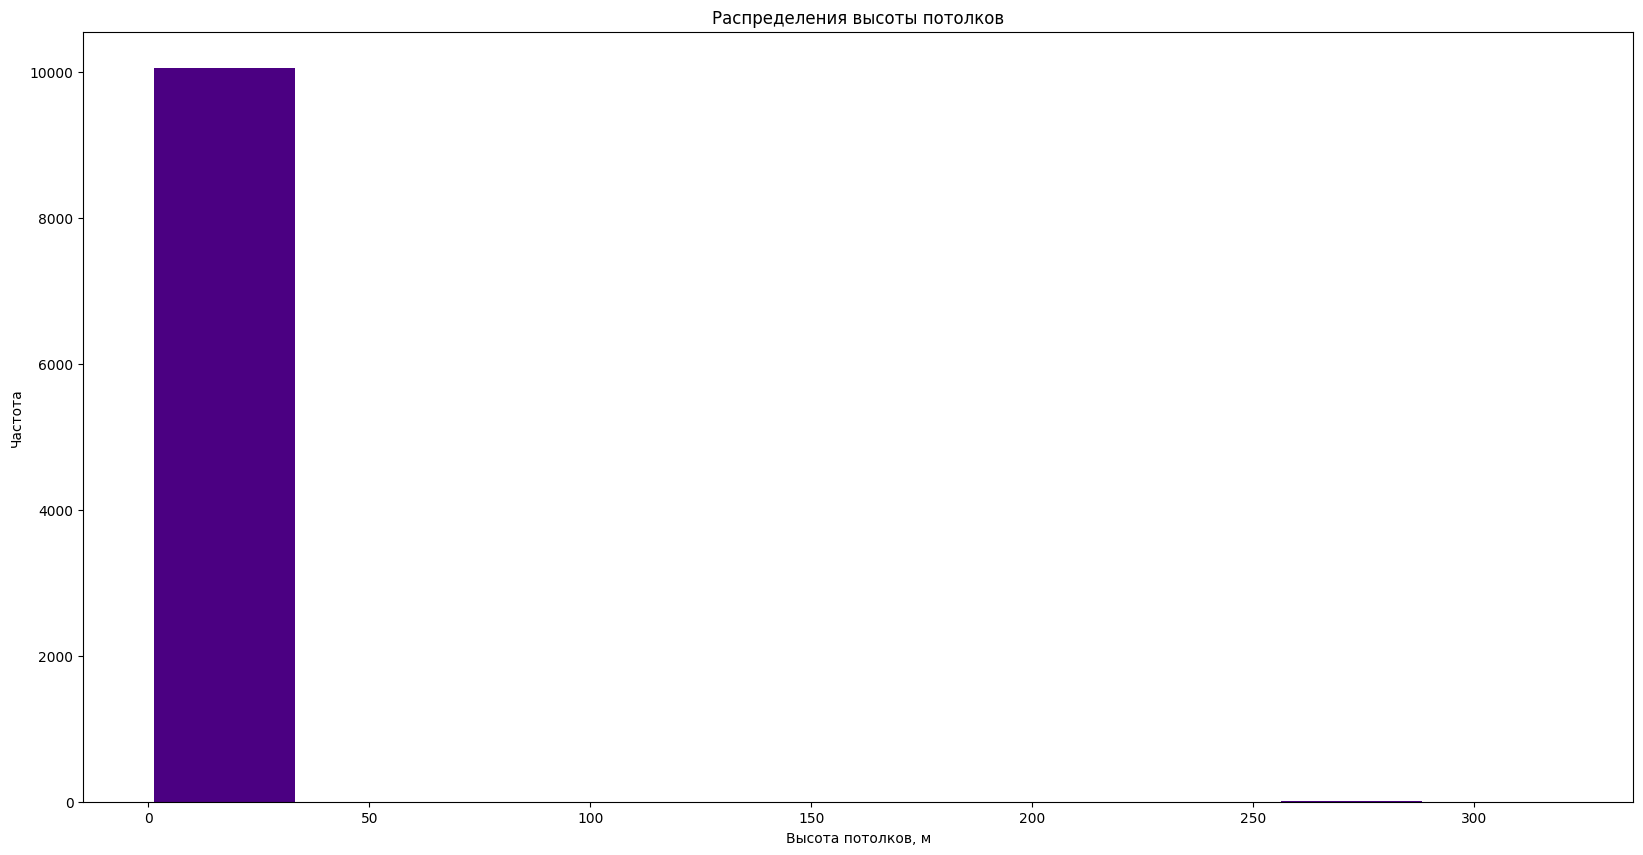

In [1080]:
fig = plt.subplots(figsize=(20, 10))
plt.hist(df['Высота потолков, м'], color='indigo')#, bins=200)
plt.xlabel('Высота потолков, м')
plt.ylabel('Частота')
plt.title('Распределения высоты потолков');

В выборке присутстуют аномально большие размеры. Удалим их

In [1081]:
# Установка верхнего и нижнего пределов
lower_limit = 2.0  # Нижний предел
upper_limit = 5.0  # Верхний предел

#Заменяем пропуски в столбце ['Высота потолка']на среднее
df['Высота потолков, м'].fillna(df['Высота потолков, м'].mean(), inplace=True)

# Фильтрация значений высоты потолков
df = df[(df['Высота потолков, м'] >= lower_limit) & (df['Высота потолков, м'] <= upper_limit)]

## 21. Лифт

In [1082]:
df['Лифт'].value_counts()

Лифт
Пасс (1)              4697
Пасс (2)              3810
Пасс (1), Груз (1)    3215
Пасс (2), Груз (1)     995
Пасс (2), Груз (2)     537
Пасс (3)               519
Пасс (4)               282
Пасс (1), Груз (2)     152
Пасс (3), Груз (1)     151
Груз (1)                55
Пасс (4), Груз (2)      54
Пасс (4), Груз (1)      46
Пасс (3), Груз (3)      39
Пасс (3), Груз (2)      33
Пасс (4), Груз (4)      20
Груз (2)                18
Груз (4)                17
Груз (3)                14
Пасс (6)                 6
Пасс (1), Груз (3)       5
Пасс (4), Груз (3)       2
Пасс (60)                2
Пасс (2), Груз (3)       2
Пасс (50)                2
Пасс (8), Груз (8)       1
Пасс (7)                 1
Пасс (5), Груз (3)       1
Пасс (2), Груз (4)       1
Груз (6)                 1
Груз (8)                 1
Пасс (5)                 1
Name: count, dtype: int64

In [1083]:
print_useful_rows_info(df['Лифт'])

Количество пустых ячеек: 3951
Процент пустых ячеек: 21.21%


In [1084]:
# Избавляемся от NaN, если меньше 5 этажей - нет лифта, в остальном по одному каждого лифта
df['Лифт'] = [row if row == row else ['Пасс (1), Груз (1)' if df['amount_floors'].iloc[i] > 5 else 'Пасс (0), Груз (0)'][0]
              for i, row in enumerate(df['Лифт'])]

In [1085]:
# Разбиваем колонку с лифтами на две раздельные 
df['passenger_elevator'] = [row.split(' ')[1] if (row.split(' ')[0]) == 'Пасс' else '(0)' for row in df['Лифт']]
df['service_elevator'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Груз' else '(0)' for row in df['Лифт']]

In [1086]:
# Убираем скобки
df['passenger_elevator'] = [row.split('(')[1] for row in df['passenger_elevator']]
df['passenger_elevator'] = [int(row.split(')')[0]) for row in df['passenger_elevator']]
df['service_elevator'] = [row.split('(')[1] for row in df['service_elevator']]
df['service_elevator'] = [int(row.split(')')[0]) for row in df['service_elevator']]

## 22. Мусопровод

Количество пустых ячеек: 7524
Процент пустых ячеек: 40.38%


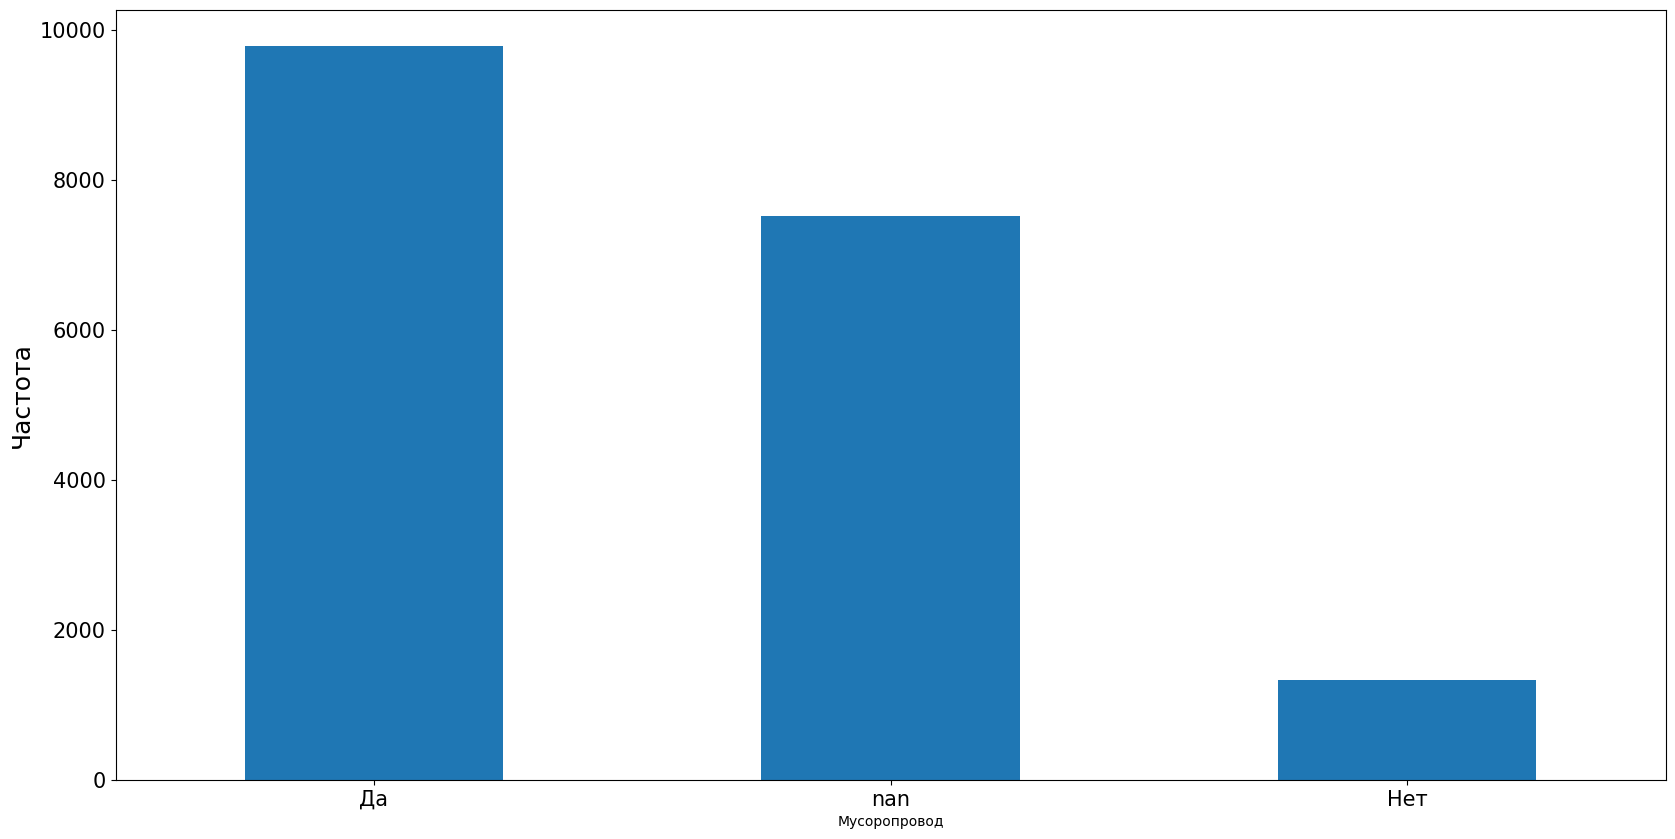

In [1087]:
print_useful_rows_info(df['Мусоропровод'])
draw_graph(df['Мусоропровод'])

In [1088]:
# Заполняем NaNы и вместо Да заполняем 1, вместо Нет - 0
df['Мусоропровод'] = df['Мусоропровод'].fillna(0)
df['Мусоропровод'].replace({'Да': 1, 'Нет': 0}, inplace=True)

## 23. Ссылка на объявление

Все значения уникальны, поэтому удаляем столбец

In [1089]:
df.drop('Ссылка на объявление', axis=1, inplace=True)

# Переименование стобцов и значений в категориальных признаках на английский

In [1090]:
df.rename(columns = {'Высота потолков, м': 'eiling_height', 'Окна': 'windows', 
                     'Парковка': 'parking', 'Ремонт': 'repair', 'Мусоропровод': 'garbage'}, inplace = True)

In [1091]:
df['type_room'].replace({'Свободная планировка': 'free_layout', 'Изолированная': 'isolated_layout', 
                       'Оба варианта': 'both_layouts', 'Смежная': 'adjacent_layout'}, inplace=True)

In [1092]:
df['district'].replace({'МКАД': 'mkad', 'ЗАМКАД': 'zamkad', 
                       'ТТК': 'ttk', 'Садовое кольцо': 'garden_ring'}, inplace=True)

In [1093]:
df['type_hous'].replace({'Панельный': 'panel', 'Кирпичный': 'brick', 'Монолитный': 'mono',
                       'Блочный': 'block', 'Монолитно-кирпичный': 'monob', 'Сталинский': 'stalin', 'старый фонд': 'old'}, inplace=True)

In [1094]:
df['windows'].replace({'Во двор': 'courtyard_windows', 'На улицу и двор': 'courtyard_and_street_side_windows', 
                       'На улицу': 'street side_windows'}, inplace=True)

In [1095]:
df['parking'].replace({'открытая': 'open', 'наземная': 'ground_level', 'подземная': 'underground',
                      'многоуровневая': 'multi_level', 'на крыше': 'on_ the_roof'}, inplace=True)

In [1096]:
df['repair'].replace({'Косметический': 'renovation_repair', 'Евроремонт': 'euro_repair', 
                      'Дизайнерский': 'designers', 'Без ремонта': 'no_repair'}, inplace=True)

In [1097]:
df.rename(columns = {'ID  объявления': 'ID'}, inplace = True)

In [1098]:
df.columns

Index(['ID', 'Количество комнат', 'Метро', 'Адрес', 'Площадь, м2', 'Дом',
       'parking', 'Цена', 'repair', 'Балкон', 'windows', 'Санузел',
       'Можно с детьми/животными', 'Дополнительно', 'eiling_height', 'Лифт',
       'garbage', 'count_room', 'type_room', 'metro', 'time_to_metro',
       'Адрес_new', 'lat', 'long', 'distance_center', 'district', 'area',
       'floor', 'amount_floors', 'type_hous', 'price', 'currency_rent',
       'rental period', 'prepayment', 'balcony', 'loggia', 'balcony_count',
       'loggia_count', 'toilet_join', 'toilet_sep', 'toilet_join_count',
       'toilet_sep_count', 'children', 'animal', 'fridge', 'bath',
       'shower_bath', 'conditioner', 'washing_machine', 'furniture_room',
       'internet', 'dishwasher', 'tv', 'kitchen_furniture', 'telephone',
       'passenger_elevator', 'service_elevator'],
      dtype='object')

In [1099]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18631 entries, 0 to 18657
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18631 non-null  int64  
 1   Количество комнат         18181 non-null  object 
 2   Метро                     18631 non-null  object 
 3   Адрес                     18631 non-null  object 
 4   Площадь, м2               18631 non-null  object 
 5   Дом                       18631 non-null  object 
 6   parking                   18631 non-null  object 
 7   Цена                      18631 non-null  object 
 8   repair                    18631 non-null  object 
 9   Балкон                    18631 non-null  object 
 10  windows                   18631 non-null  object 
 11  Санузел                   18631 non-null  object 
 12  Можно с детьми/животными  14015 non-null  object 
 13  Дополнительно             18392 non-null  object 
 14  eiling_heig

# Удаляем все использованные столбцы для извлечения

Также удаляем новые признаки:
- 'lat', 'long', 'distance_center' - вместо их будем использовать только district - указывающий на отдаленность от центра Москвы
- 'currency_rent', 'telephone', 'prepayment', 'rental period',  'washing_machine' - так как у них преобладает одно значение
- 'balcony', 'loggia', 'toilet_join', 'toilet_sep' - вместо их будем использовать только количество санузлов по типам и количество балконов/лоджий

In [1100]:
drop_col = ['Количество комнат', 'Метро', 'Адрес', 'Площадь, м2', 'Дом', 'Цена', 'Балкон', 'Санузел', 'Можно с детьми/животными', 
            'Дополнительно', 'Лифт', 'metro', 'Адрес_new', 'lat', 'long', 'distance_center', 'currency_rent', 'balcony', 
            'loggia', 'toilet_join', 'toilet_sep', 'telephone', 'prepayment', 'rental period',  'washing_machine']

In [1101]:
df.drop(drop_col, axis=1, inplace=True)

In [1102]:
df.to_csv('data.csv')

**********

# Стандартизация данных

In [1103]:
# числовые фичи
watch_features = ['eiling_height', 'count_room', 'time_to_metro', 'area', 'floor', 'amount_floors', 'balcony_count', 
                  'loggia_count', 'toilet_join_count', 'toilet_sep_count', 'passenger_elevator', 'service_elevator']
# категориальны фичи
category_feature = ['parking', 'repair', 'windows', 'type_room', 'district', 'type_hous']

In [1104]:
# масштабируем числовые фичи
std_scaler = StandardScaler()
std_scaler.fit(df[watch_features])
std_scaled = std_scaler.transform(df[watch_features])
names_new = []
for name in watch_features:
    col_name = name + '_std'
    names_new.append(col_name)
df[names_new] = std_scaled

In [1105]:
# кодируем категориальнеы фичи
ohe = OneHotEncoder(sparse=False)
ohe.fit(df[category_feature])
ohe_new = ohe.transform(df[category_feature])
df[ohe.get_feature_names_out()] = ohe_new

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1106]:
df.drop(category_feature, axis=1, inplace=True)
df.drop(watch_features, axis=1, inplace=True)

## Корреляция

Выведем все признаки, у которых коррреляция с price меньше 0.2 и удалим их из датафрейма

In [1107]:
df1 = df.corr().round(3)
df1 = df1[:9]
df1 = df1.loc["price"]
df1 = df1.abs()
df1_filtered = df1.mask(df1 > 0.2)
df1_filtered = pd.DataFrame(df1_filtered).dropna()
df1_filtered.reset_index(inplace=True)
b = []
for i in range(len(df1_filtered)):
    if abs(df1_filtered['price'][i]) < 0.2:
        b.append(df1_filtered['index'][i])
b

['ID',
 'garbage',
 'children',
 'animal',
 'fridge',
 'bath',
 'furniture_room',
 'internet',
 'tv',
 'kitchen_furniture',
 'time_to_metro_std',
 'floor_std',
 'amount_floors_std',
 'balcony_count_std',
 'loggia_count_std',
 'toilet_sep_count_std',
 'passenger_elevator_std',
 'service_elevator_std',
 'parking_ground_level',
 'parking_multi_level',
 'parking_on_ the_roof',
 'parking_open',
 'repair_euro_repair',
 'repair_no_repair',
 'windows_courtyard_windows',
 'windows_street side_windows',
 'type_room_adjacent_layout',
 'type_room_both_layouts',
 'type_room_free_layout',
 'type_room_isolated_layout',
 'district_ttk',
 'district_zamkad',
 'type_hous_block',
 'type_hous_brick',
 'type_hous_mono',
 'type_hous_monob',
 'type_hous_old',
 'type_hous_panel',
 'type_hous_stalin']

In [1108]:
df.drop(b[1:], axis=1, inplace=True)

In [1109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18631 entries, 0 to 18657
Data columns (total 15 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         18631 non-null  int64  
 1   price                                      18631 non-null  int64  
 2   shower_bath                                18631 non-null  int64  
 3   conditioner                                18631 non-null  int64  
 4   dishwasher                                 18631 non-null  int64  
 5   eiling_height_std                          18631 non-null  float64
 6   count_room_std                             18631 non-null  float64
 7   area_std                                   18631 non-null  float64
 8   toilet_join_count_std                      18631 non-null  float64
 9   parking_underground                        18631 non-null  float64
 10  repair_designers           

In [1110]:
df.to_csv('data_final.csv', index=False)